Telecom Churn Prediction

https://www.kaggle.com/competitions/telecom-churn-case-study-hackathonc62/overview

highest prediction accuracy submitted:0.9

0. Problem statement
---------------------------------
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is to build a machine learning model that is able to predict churning customers based on the features provided for their usage.

Customer behaviour during churn:

Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

In [ ]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from imblearn.pipeline import make_pipeline
#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

##1. Reading dataset

In [ ]:
# Reading the dataset
data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

#Dimension of the training dataset
print(data.shape)

#Dimension of the unseen dataset
print(unseen.shape)

#Dimension of the sample dataset
print(sample.shape)

#Dimension of the training dataset
print(data_dict.shape)

In [ ]:
#output the data dictionary
data_dict

In [ ]:
## load data statistics for the training dataset
data.describe()

## 2. EDA

###2.1 data preperation & cleaning

**A. checking columns in training data with one unique value**

In [ ]:
#search for columns with single value
single_value_cols = [col for col in data.columns if data[col].nunique() == 1]
print(single_value_cols)


now we can drop those columns to execlude from training as
it doesn't provide any meaningful information for the model. Keeping such columns in the train and test set would similarly provide no value and could even lead to unnecessary complexity or **noise** in model's predictions

'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8'

In [ ]:
#show details for the single values columns
for col in single_value_cols:
    print(f"Column: {col}")
    print(data[col].value_counts(dropna=False))
    print("_" * 20)



In [ ]:
#drop columns from testing and training
data.drop(single_value_cols, axis=1, inplace=True)
unseen.drop(single_value_cols, axis=1, inplace=True)

**B. remove columns for unique value in every row**

In [ ]:
data.drop('id', axis=1, inplace=True)

**C. non useful**

In [ ]:

date_cols = ['date_of_last_rech_6',
            'date_of_last_rech_7',
            'date_of_last_rech_8',
            'date_of_last_rech_data_6',
            'date_of_last_rech_data_7',
            'date_of_last_rech_data_8',
            ]
 # Dropping date columns as they are not useful for our analysis from the training set
data.drop(columns=date_cols, axis=1, inplace=True)
# Dropping date columns as they are not useful for our analysis from the test set
unseen.drop(columns=date_cols, axis=1, inplace=True)

### 2.2 handle missing values

In [ ]:
# Calculate the percentage of missing values for each column in the training dataset
missing_values_train = (data.isna().sum() / data.shape[0]) * 100

# Filter columns with more than 70% missing values and sort them in descending order
columns_with_high_missing_values = missing_values_train[missing_values_train > 70].sort_values(ascending=False)

# Display the columns
print(columns_with_high_missing_values)


#### **A. handle missing values on columns related to reacharge**

In [ ]:
#List of recharge columns
recharge_cols =[
    'max_rech_data_6',
    'max_rech_data_7',
    'max_rech_data_8',
    'count_rech_2g_6',
    'count_rech_3g_6',
    'count_rech_2g_7',
    'count_rech_3g_7',
    'count_rech_2g_8',
    'count_rech_3g_8',
    'total_rech_data_6',
    'total_rech_data_8',
    'total_rech_data_7',
    'av_rech_amt_data_6',
    'av_rech_amt_data_7',
    'av_rech_amt_data_8'
]

In [ ]:

# Calculate and print the number of NaN values for each column
for col in recharge_cols:
    num_nan = data[col].isna().sum()
    print(f'Column {col} has {num_nan} NaN values')


In [ ]:
# Replacing NaN values in recharge columns with 0 in the training set
data[recharge_cols] = data[recharge_cols].fillna(0)
print(data[recharge_cols].isnull().sum()*100/data.shape[1])

In [ ]:
# Calculate and print the number of NaN values for each column in testing set
for col in recharge_cols:
    num_nan = unseen[col].isna().sum()
    print(f'Column {col} has {num_nan} NaN values')


In [ ]:
# Replacing NaN values in recharge columns with 0 in the test set
unseen[recharge_cols] = unseen[recharge_cols].fillna(0)
print(unseen[recharge_cols].isnull().sum()*100/unseen.shape[1])

#### **B. handle missing values on columns related to ARPU**

In [ ]:
# Columns with 'arpu' information
arpu_cols = data.columns[data.columns.str.contains('arpu_')]
print(arpu_cols)

In [ ]:
# Calculate and print the number of NaN values for each column in testing set
for col in arpu_cols:
    num_nan = unseen[col].isna().sum()
    print(f'Column {col} has {num_nan} NaN values')


In [ ]:
arpu_cols=[
    'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
       'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8'
]

In [ ]:
# Replacing NaN values in ARPU related columns with 0 in the training set
data[arpu_cols] = data[arpu_cols].fillna(0)
print(data[arpu_cols].isnull().sum()*100/data.shape[1])

In [ ]:
# Replacing NaN values in ARPU related columns with 0 in the testing set
unseen[arpu_cols] = unseen[arpu_cols].fillna(0)
print(unseen[arpu_cols].isnull().sum()*100/unseen.shape[1])

####**C.Handle missing values for categorical data**

In [ ]:
cat_cols = ['night_pck_user_6',
            'night_pck_user_7',
            'night_pck_user_8',
            'fb_user_6',
            'fb_user_7',
            'fb_user_8',
           ]
 # Replacing NaN values in categorical related columns with -1 in the training set.
# convert from `float64` data type to category datatype

data[cat_cols] = data[cat_cols].fillna(-1).astype('category')
print(data[cat_cols].isnull().sum()*100/data.shape[1])

In [ ]:
## replace Nan values in the testing set for categorical values columns
unseen[cat_cols] = unseen[cat_cols].fillna(-1).astype('category')
print(unseen[cat_cols].isnull().sum()*100/unseen.shape[1])

###2.3 Feature Optimization and selection

In [ ]:
# Checking for the columns which have missing values present

missing_values_train[(missing_values_train > 0) & (missing_values_train <= 70)].sort_values(ascending=False)

In [ ]:

missing_values_list = missing_values_train[(missing_values_train > 0) & (missing_values_train <= 70)].index
print(missing_values_list)

In [ ]:


# Deriving new columns for Total Data Recharge Amount for the 'Good Phase'
data['total_rech_data_amt_6'] = data['total_rech_data_6'] * data['av_rech_amt_data_6']
data['total_rech_data_amt_7'] = data['total_rech_data_7'] * data['av_rech_amt_data_7']

# Deriving Total Amount for months 6 and 7
data['total_amt_6'] = data['total_rech_data_amt_6'] + data['total_rech_amt_6']
data['total_amt_7'] = data['total_rech_data_amt_7'] + data['total_rech_amt_7']

# Computing Total Average Amount during the 'Good Phase' (months 6 and 7)
data['total_avg_amt_6_7'] = data[['total_amt_6', 'total_amt_7']].mean(axis=1)

# Dropping columns that are no longer useful for high-value customer analysis or churn
drop_data_cols = [
    'total_rech_data_amt_6',
    'total_rech_data_amt_7',
    'av_rech_amt_data_6',
    'av_rech_amt_data_7',
    'av_rech_amt_data_8',
    'total_rech_data_6',
    'total_rech_data_7',
    'total_rech_data_8'
]

data.drop(columns=drop_data_cols, axis=1, inplace=True)

In [ ]:


# Deriving new columns for Total Data Recharge Amount for the 'Good Phase'
unseen['total_rech_data_amt_6'] = unseen['total_rech_data_6'] * unseen['av_rech_amt_data_6']
unseen['total_rech_data_amt_7'] = unseen['total_rech_data_7'] * unseen['av_rech_amt_data_7']

# Deriving Total Amount for months 6 and 7
unseen['total_amt_6'] = unseen['total_rech_data_amt_6'] + unseen['total_rech_amt_6']
unseen['total_amt_7'] = unseen['total_rech_data_amt_7'] + unseen['total_rech_amt_7']

# Computing Total Average Amount during the 'Good Phase' (months 6 and 7)
unseen['total_avg_amt_6_7'] = unseen[['total_amt_6', 'total_amt_7']].mean(axis=1)

unseen.drop(columns=drop_data_cols, axis=1, inplace=True)

In [ ]:
# there should be no null value in the new feature column
#checking null values count
data['total_avg_amt_6_7'].isnull().sum()

In [ ]:
print(data.shape)
print(unseen.shape)

Quantile Calculation: The quantile function calculates the value below which a given percentage of observations in the dataset fall. For example, quantile(0.7) calculates the value below which 70% of the data in the total_avg_amt_6_7 column lies.

Cutoff Value: By computing the 70th percentile (i.e., the value corresponding to 0.7 quantile), you identify the threshold above which the top 30% of high-value customers will fall.

If a customer’s total_avg_amt_6_7 is above this cutoff, they are in the top 30% of customers in terms of their average recharge amount for months 6 and 7.
If a customer’s total_avg_amt_6_7 is below this cutoff, they are in the bottom 70% of customers for the same metric.
Purpose:
Identifying High-Value Customers: This cutoff helps in filtering out the top 30% of high-value customers for further analysis or targeted actions.
Segmenting Data: By setting this threshold, you can segment your data to focus on the top-performing customers, which can be useful for targeted marketing or understanding behavior patterns of high-value customers.

In [ ]:
# Finding cutoff value for only top 70% of high value customers
cutoff = data['total_avg_amt_6_7'].quantile(0.7)
cutoff


In [ ]:
# Filter high value customers in the new dataframe (high_val_train) where total recharge is more than 477.5
high_val_train = data[(data['total_avg_amt_6_7'] > cutoff)].copy()

print(high_val_train.shape)

###2.4 imputing missing values for churn_probability


####2.4.1 Analyzing

In [ ]:
## analyzing churn_probability and class imbalance
## analyzing churn_probability and class imbalance
high_val_train['churn_probability'].dtype

In [ ]:
high_val_train['churn_probability'] = high_val_train['churn_probability'].astype('category')

In [ ]:
# Check the value counts of churn and not-churn
print(high_val_train['churn_probability'].value_counts())
print('-------------------------------------------------')
# Calculate churn ratio
print('Churn ratio:')
print(high_val_train['churn_probability'].value_counts()*100/high_val_train.shape[0])

churn is arount 9% from the high value set
a noticeable class imbalance in **churn_probability**

In [ ]:
# Visualize churn distribution
plt.figure(figsize=(2,2))
sns.countplot(x = high_val_train['churn_probability'])
plt.xlabel('Customer churn', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.title('Customer churn distribution', fontsize=8)
plt.show()

In [ ]:
churn_data = high_val_train.copy()
churn_data.reset_index(inplace=True)
churn_data.drop(['index'], axis=1, inplace=True)


In [ ]:
print(churn_data.shape)

In [ ]:
# Get the list of columns with missing values in the training set
mv = round(100 * (churn_data.isnull().sum(axis=0) / churn_data.shape[0]), 2)

# Filter columns with any missing values
s = mv.loc[mv > 0]

# List of columns with missing values
impute_cols_num = list(s.index)

# Print the number of columns with missing values
print("number of columns with missing values:" ,len(impute_cols_num))

# Check how many rows have missing values by comparing with a DataFrame with missing values dropped
drop = churn_data.dropna()

# Calculate the number of rows with missing values
missing_rows = churn_data.shape[0] - drop.shape[0]

# Print the number of rows with missing values
print("number of missing rows:",missing_rows)


#### 2.4.2 Impute

*In this section, we address the challenge of missing values in our training set. Discarding rows with missing values is not a viable option, as it would result in the loss of potentially valuable information. To handle missing values effectively, we will employ imputation techniques, specifically the **KNN Imputer**.*

Why KNN Imputer?
KNNImputer is a powerful technique used to impute missing values based on the values of the nearest neighbors. Here's why we have chosen KNN Imputer for this task:

Similarity-Based Imputation: KNN Imputer utilizes the similarity between data points. By identifying the
𝑘
k nearest neighbors of each data point with missing values, it estimates missing values based on the values of these similar data points. This method leverages the inherent patterns and relationships in the data, providing more accurate imputation compared to simple statistical methods like mean or median imputation.

Preservation of Data Patterns: Unlike mean or median imputation, which may oversimplify the imputation by filling in missing values with a single value for all instances, KNN Imputer takes into account the local structure of the data. This means that the imputed values are more reflective of the data's distribution and relationships, preserving the underlying patterns and variability.

Flexibility: KNN Imputer can handle both numerical and categorical data, making it versatile for different types of datasets. It also allows for the adjustment of
𝑘
k (the number of neighbors) to fine-tune the imputation process based on the specific characteristics of the dataset.

Reduced Bias: By considering multiple nearest neighbors, KNNImputer reduces the risk of introducing bias that might occur with simpler imputation techniques. It provides a more balanced and representative imputation, which can enhance the performance of subsequent models trained on the imputed data.

No Assumptions About Data Distribution: KNNImputer does not assume any specific distribution of the data, making it suitable for datasets with complex and non-linear relationships between features.

In [ ]:
from sklearn.impute import KNNImputer
# Create imputer instance
imputer = KNNImputer(n_neighbors=4)
# df_imp_knn = knn_imputer.fit_transform(df_train)

df_num = churn_data[impute_cols_num]
churn_df = churn_data.drop(impute_cols_num, axis=1)

In [ ]:
%%time
df_imp = imputer.fit_transform(df_num)

In [ ]:
imputer = KNNImputer(n_neighbors=5)
# df_imp_knn = knn_imputer.fit_transform(df_train)


df_num = churn_data[impute_cols_num]
churn_df = churn_data.drop(impute_cols_num, axis=1)

In [ ]:
%%time
df_imp = imputer.fit_transform(df_num)

In [ ]:

# Convert it to df post imputation
df_imp = pd.DataFrame(df_imp, columns=impute_cols_num)
df_imp.head()

In [ ]:
#Merge the two dataframes together post imputation to create the final data frame
final_df = pd.concat([df_imp, churn_df], join='inner', axis=1)
final_df.head()

In [ ]:
final_df.shape

In [ ]:
#verify no missing values
missing_cols = final_df.isnull().sum()
num_missing_cols = missing_cols[missing_cols > 0].count()
print(f'Number of columns with missing values: {num_missing_cols}')

repeate the imputing process for the unseen data:

In [ ]:
df_num_unseen = unseen[impute_cols_num]
churn_df_unseen = unseen.drop(impute_cols_num, axis=1)

In [362]:
%%time
# Impute using KNN imputer instance
df_imp_unseen = imputer.transform(df_num_unseen)

CPU times: user 58.2 s, sys: 16.9 s, total: 1min 15s
Wall time: 1min 14s


In [ ]:

# Convert it to df post imputation
df_imp_unseen = pd.DataFrame(df_imp_unseen, columns=impute_cols_num)
df_imp_unseen.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0        31.78        20.23        23.11         60.16         32.16   
1        75.51        41.21        19.84        474.34        621.84   
2         7.54         7.86         8.40         16.98         45.81   
3         5.31         2.16         0.00         40.04        205.01   
4       450.93       609.03       700.68         60.94         23.84   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0         34.83           0.00           0.00           0.00           0.00   
1        394.94           0.00           0.00           0.00           0.00   
2         45.04          22.81         103.38          26.08          24.53   
3         24.01           0.00           0.00           0.00           0.00   
4         74.16           0.00           0.00           0.00           0.00   

   ...  std_ic_mou_8  spl_ic_mou_6  spl_ic_mou_7  spl_ic_mou_8  isd_ic_mou_6  \
0  ...          4.34          0.54          0.34          0.39          0.00   
1  ...          0.00          0.00          0.00          0.00        114.63   
2  ...          0.00          0.00          0.00          0.00          0.00   
3  ...          8.83          0.00          0.00          0.00          0.00   
4  ...        141.48          0.00          0.00          0.00          0.00   

   isd_ic_mou_7  isd_ic_mou_8  ic_others_6  ic_others_7  ic_others_8  
0          0.00          0.00          0.0          0.0         0.00  
1        177.88         94.23          0.0          0.0         0.00  
2          0.00          0.00          0.0          0.0         0.00  
3          1.43          8.65          0.0          0.0         0.00  
4          0.00          0.00          0.0          0.0         0.16  

[5 rows x 81 columns]

In [ ]:

# Merge the two dataframes together post imputation
final_unseen_df = pd.concat([df_imp_unseen, churn_df_unseen], join='inner', axis=1)
final_unseen_df.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0        31.78        20.23        23.11         60.16         32.16   
1        75.51        41.21        19.84        474.34        621.84   
2         7.54         7.86         8.40         16.98         45.81   
3         5.31         2.16         0.00         40.04        205.01   
4       450.93       609.03       700.68         60.94         23.84   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0         34.83           0.00           0.00           0.00           0.00   
1        394.94           0.00           0.00           0.00           0.00   
2         45.04          22.81         103.38          26.08          24.53   
3         24.01           0.00           0.00           0.00           0.00   
4         74.16           0.00           0.00           0.00           0.00   

   ...  fb_user_6  fb_user_7  fb_user_8   aon  aug_vbc_3g  jul_vbc_3g  \
0  ...       -1.0       -1.0       -1.0  1692        0.00        0.00   
1  ...       -1.0       -1.0       -1.0  2533        0.00        0.00   
2  ...       -1.0       -1.0       -1.0   277      525.61      758.41   
3  ...       -1.0       -1.0       -1.0  1244        0.00        0.00   
4  ...       -1.0       -1.0       -1.0   462        0.00        0.00   

   jun_vbc_3g  total_amt_6  total_amt_7  total_avg_amt_6_7  
0        0.00        103.0         90.0               96.5  
1        0.00        500.0        500.0              500.0  
2      241.84        500.0       1000.0              750.0  
3        0.00        110.0        260.0              185.0  
4        0.00        356.0        490.0              423.0  

[5 rows x 149 columns]

In [ ]:
final_unseen_df.shape

(30000, 149)

In [ ]:
#verify no missing values
missing_cols = final_unseen_df.isnull().sum()
num_missing_cols = missing_cols[missing_cols > 0].count()
print(f'Number of columns with missing values: {num_missing_cols}')

Number of columns with missing values: 0


## 3. Plotting & correlation

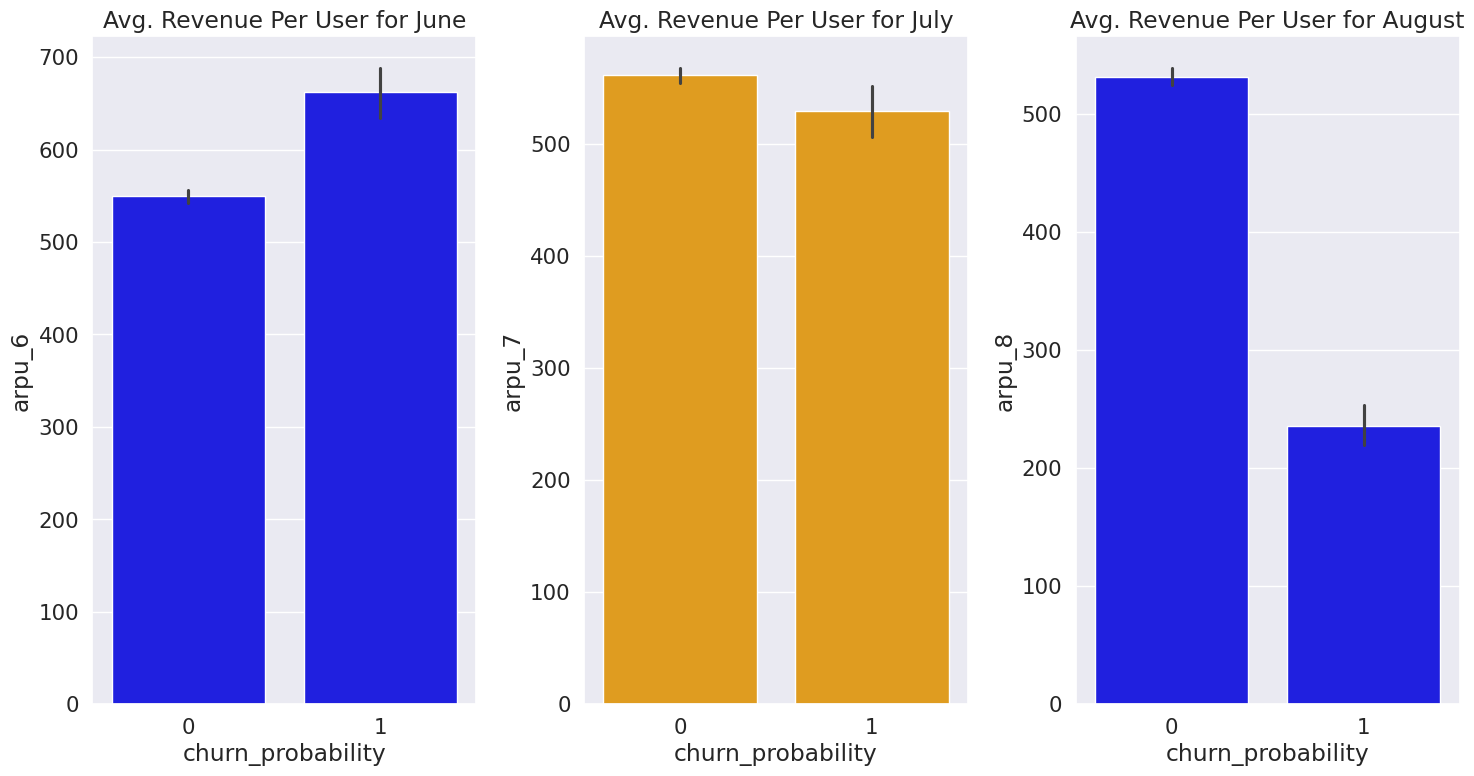

In [ ]:
# Visualising Average Revenue per user
arpu_cols = ['arpu_6', 'arpu_7', 'arpu_8']
months = ['June', 'July', 'August']

# Define colors for the bars
colors = ['blue', 'orange']

# Create a figure with subplots
plt.figure(figsize=(15, 15))

# Loop through each month and y-variable
for i, month in enumerate(months):
    plt.subplot(2, 3, i + 1)
    plt.title(f'Avg. Revenue Per User for {month}')
    # Create a custom color palette with 2 colors
    palette = [colors[i % len(colors)]]
    sns.barplot(x='churn_probability', y=arpu_cols[i], data=final_df, palette=palette)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

**The decline in the Average Revenue Per User (ARPU) in month of August suggests churn.**

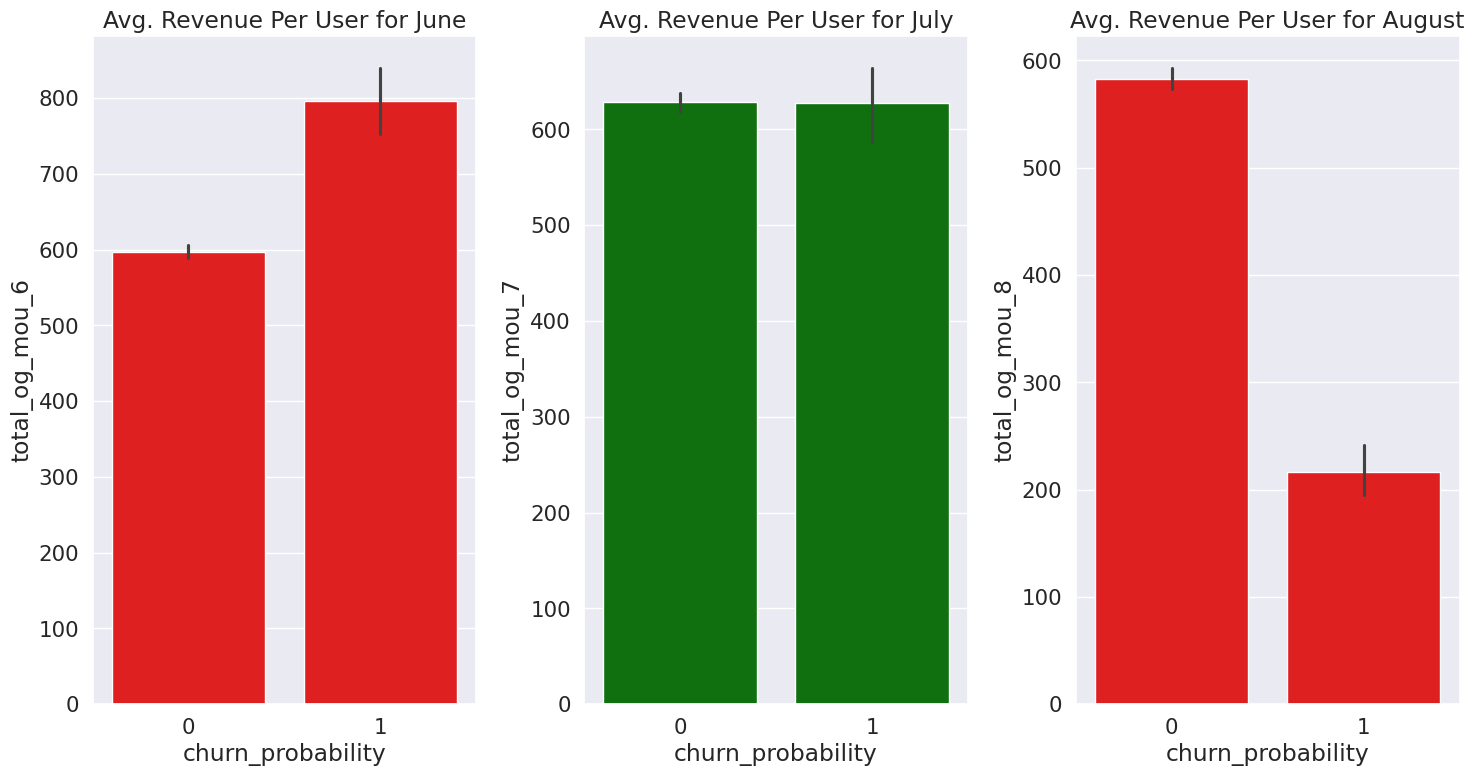

In [ ]:
# Visualising Average Revenue per user
og_cols = ['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']
months = ['June', 'July', 'August']

# Define colors for the bars
colors = ['red', 'green']  # Customize these colors as needed

# Create a figure with subplots
plt.figure(figsize=(15, 15))

# Loop through each month and y-variable
for i, month in enumerate(months):
    plt.subplot(2, 3, i + 1)
    plt.title(f'Avg. Revenue Per User for {month}')
    # Create a custom color palette with 2 colors
    palette = [colors[i % len(colors)]]
    sns.barplot(x='churn_probability', y=og_cols[i], data=final_df, palette=palette)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

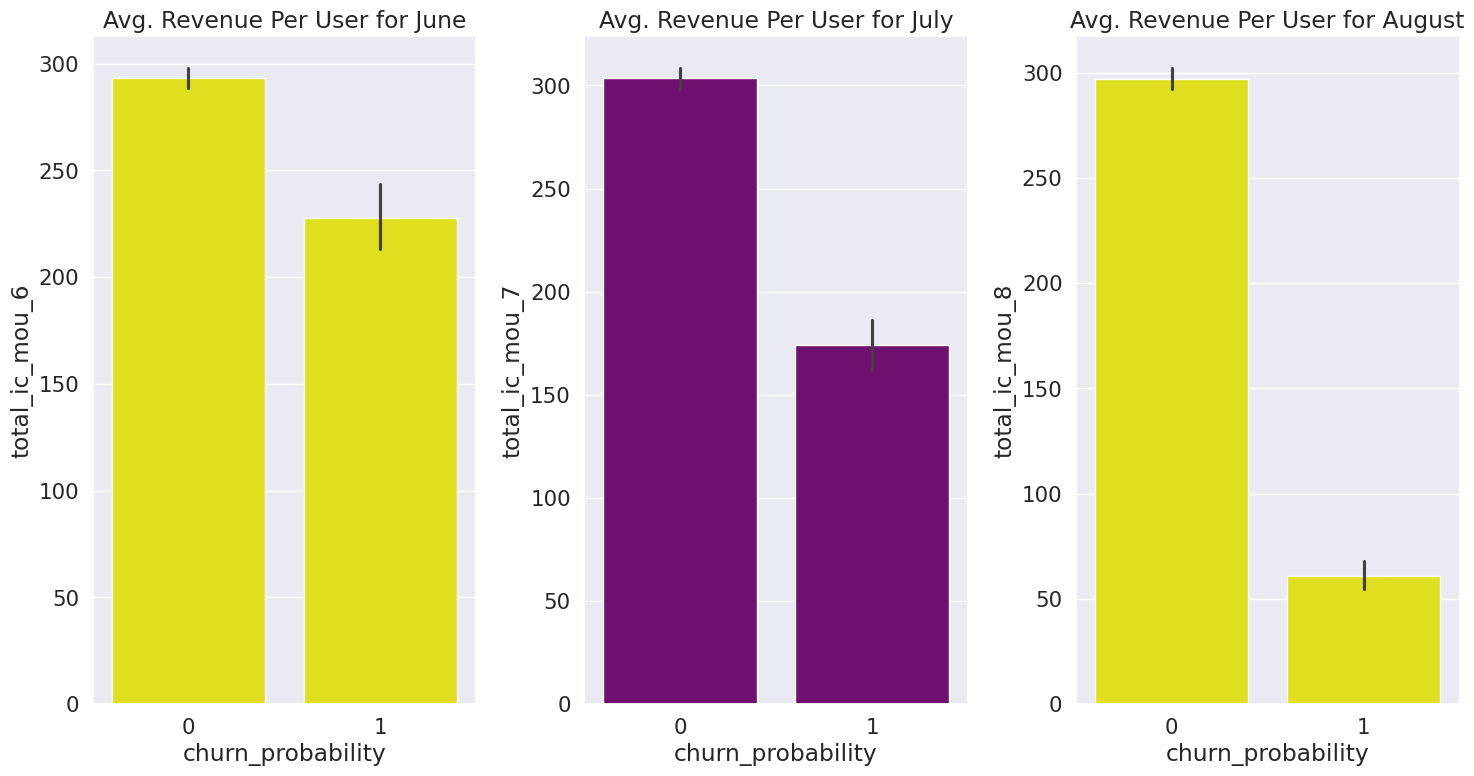

In [ ]:
# Visualising Average Revenue per user
ic_cols = ['total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']
months = ['June', 'July', 'August']

# Define colors for the bars
colors = ['yellow', 'purple']  # Customize these colors as needed

# Create a figure with subplots
plt.figure(figsize=(15,15))

# Loop through each month and y-variable
for i, month in enumerate(months):
    plt.subplot(2, 3, i + 1)
    plt.title(f'Avg. Revenue Per User for {month}')
    # Create a custom color palette with 2 colors
    palette = [colors[i % len(colors)]]
    sns.barplot(x='churn_probability', y=ic_cols[i], data=final_df, palette=palette)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

The decline in the Calls within operator network in month of August suggests churn.

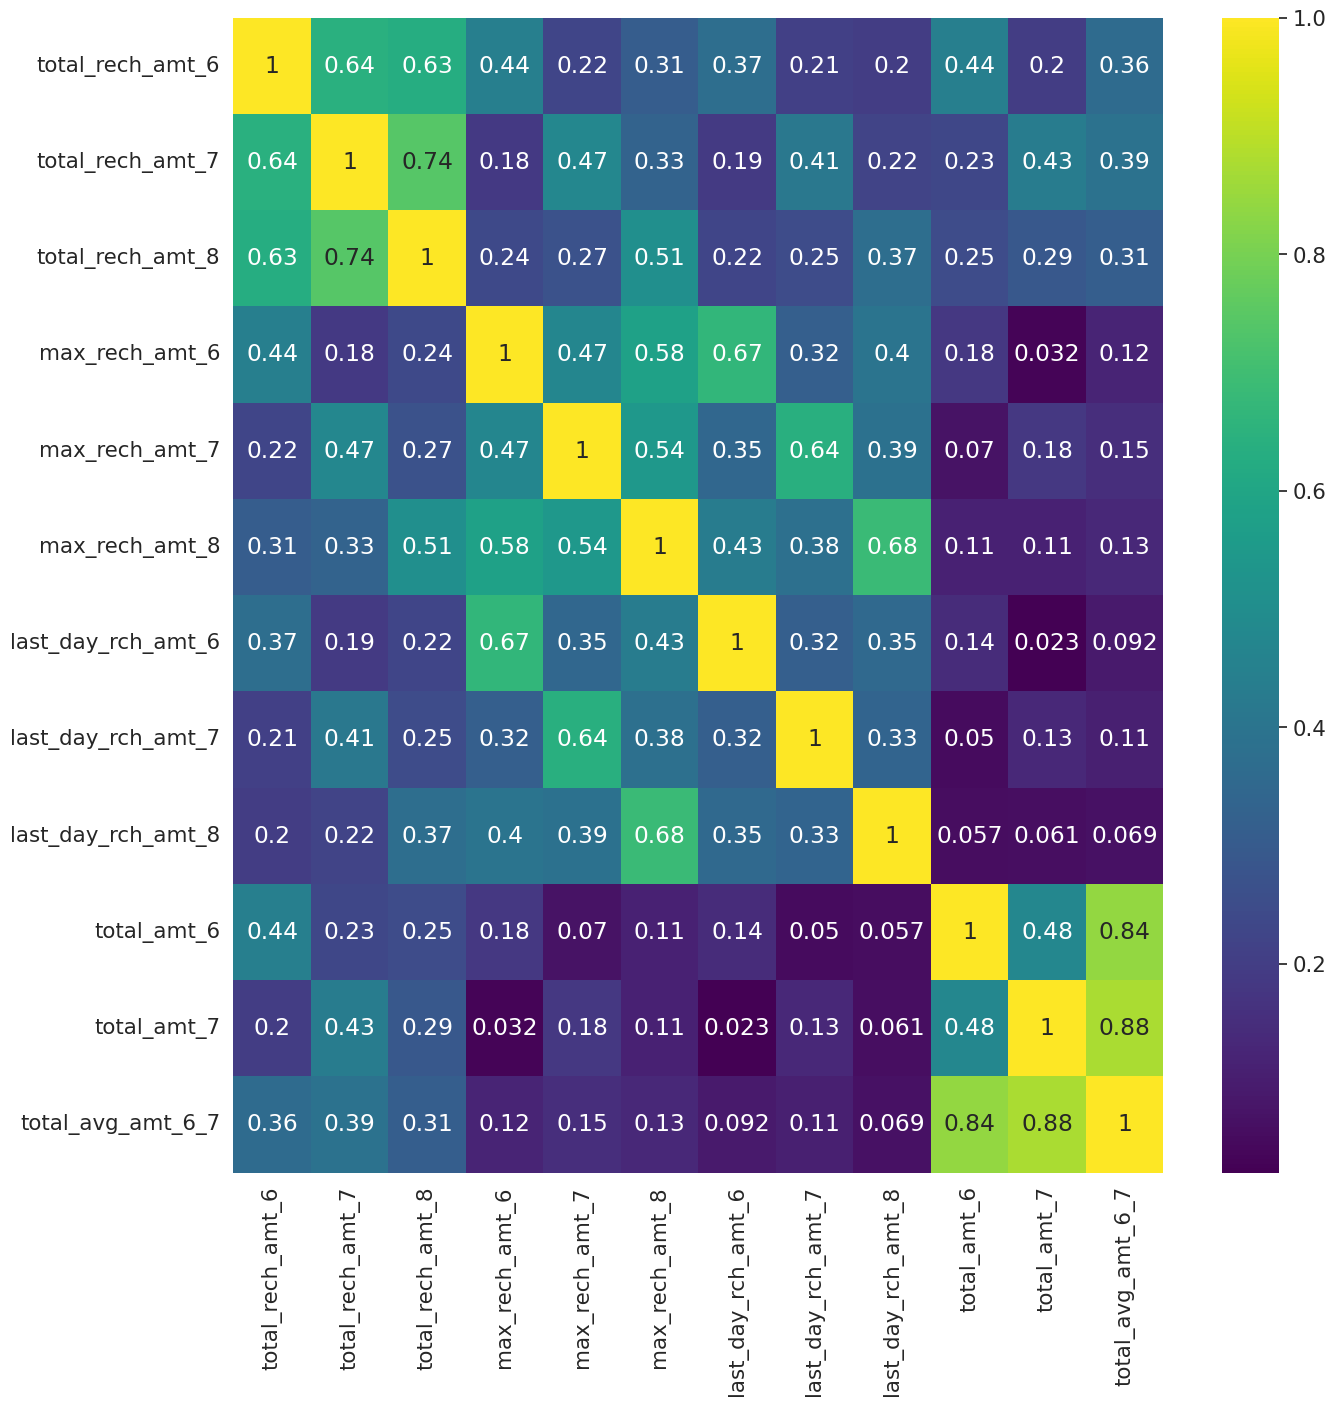

In [ ]:
amount_data = final_df.loc[:, final_df.columns.str.contains('amt')]
data2g = final_df.loc[:, final_df.columns.str.contains('2g')]
data3g = final_df.loc[:, final_df.columns.str.contains('3g')]
ic_mou_data = final_df.loc[:, final_df.columns.str.contains('ic') & final_df.columns.str.contains('mou')]
net_mou_data = final_df.loc[:, final_df.columns.str.contains('net_mou')]
og_mou_data = final_df.loc[:, final_df.columns.str.contains('og') & final_df.columns.str.contains('mou')]
rech_data = final_df.loc[:, final_df.columns.str.contains('rech')]
total_data = final_df.loc[:, final_df.columns.str.contains('tot')]
# Amount data
plt.figure(figsize=(15,15))
sns.heatmap(amount_data.corr(), annot=True, cmap='viridis')
plt.show()

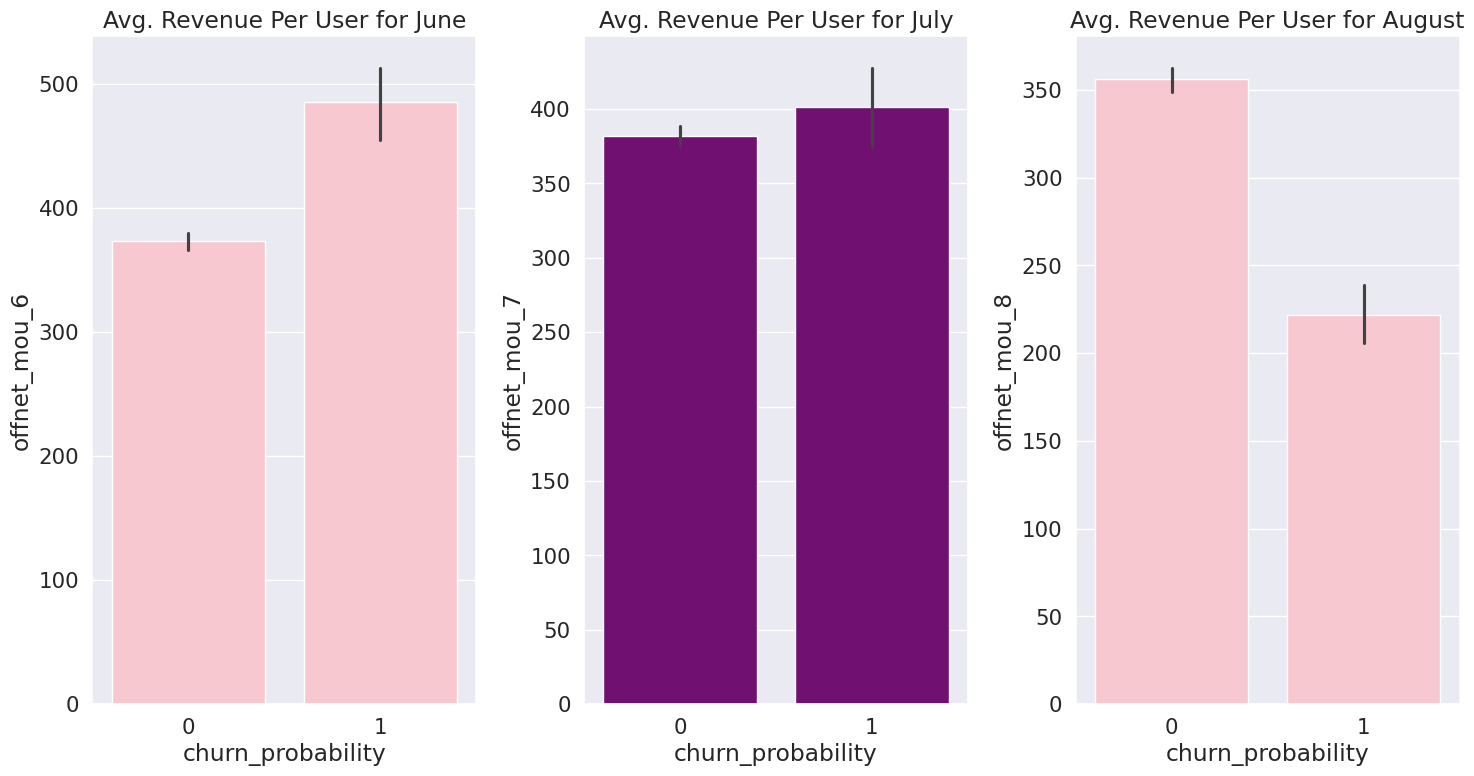

In [ ]:
# Visualising Average Revenue per user
offnet_cols = ['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']
months = ['June', 'July', 'August']

# Define colors for the bars
colors = ['pink', 'purple']  # Customize these colors as needed

# Create a figure with subplots
plt.figure(figsize=(15, 15))

# Loop through each month and y-variable
for i, month in enumerate(months):
    plt.subplot(2, 3, i + 1)
    plt.title(f'Avg. Revenue Per User for {month}')
    # Create a custom color palette with 2 colors
    palette = [colors[i % len(colors)]]
    sns.barplot(x='churn_probability', y=offnet_cols[i], data=final_df, palette=palette)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

The decline in the Calls within outside operator network in month of August suggests churn.

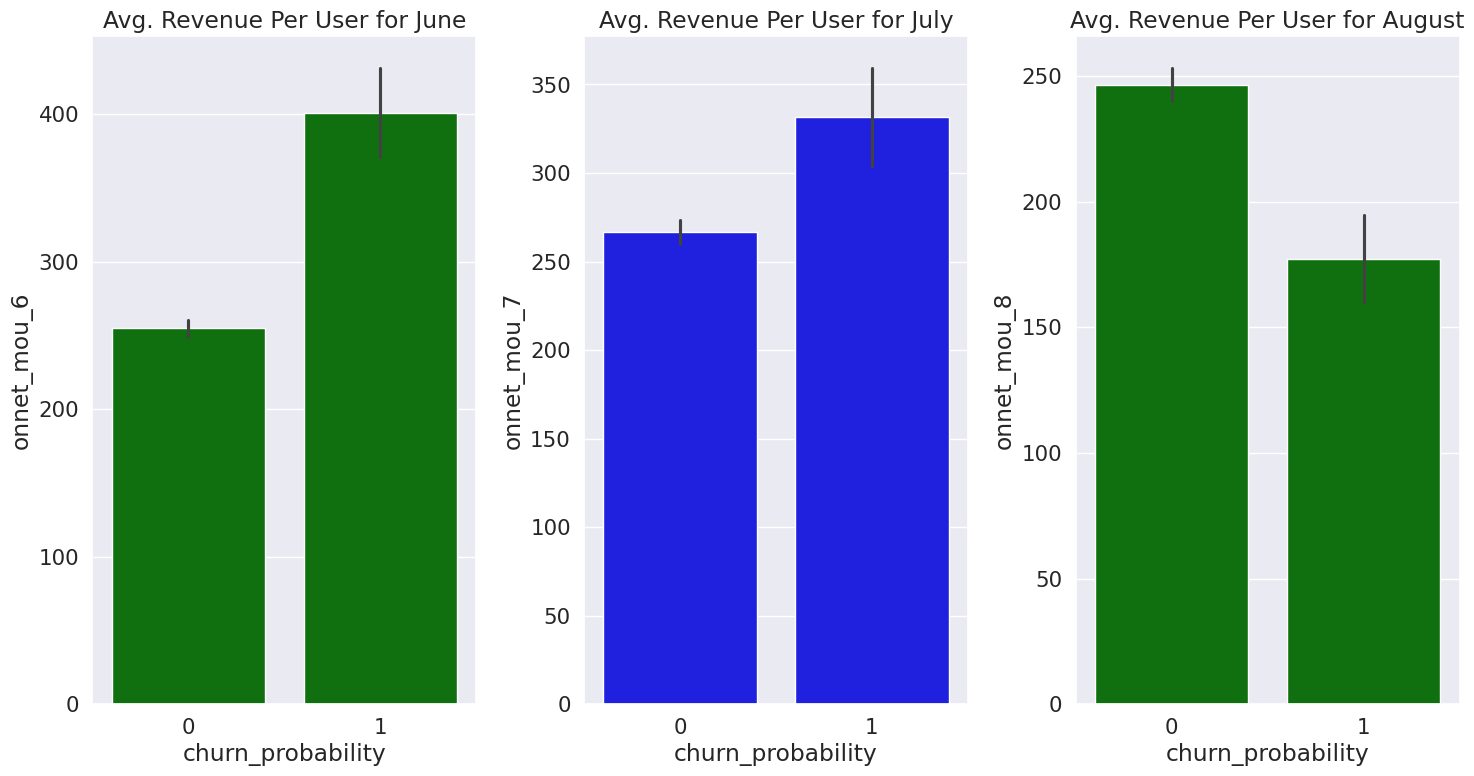

In [ ]:
# Visualising Average Revenue per user
onnet_cols = ['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']
months = ['June', 'July', 'August']

# Define colors for the bars
colors = ['green', 'blue']  # Customize these colors as needed

# Create a figure with subplots
plt.figure(figsize=(15, 15))

# Loop through each month and y-variable
for i, month in enumerate(months):
    plt.subplot(2, 3, i + 1)
    plt.title(f'Avg. Revenue Per User for {month}')
    # Create a custom color palette with 2 colors
    palette = [colors[i % len(colors)]]
    sns.barplot(x='churn_probability', y=onnet_cols[i], data=final_df, palette=palette)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

The decline in the Calls within operator network in month of August suggests churn.

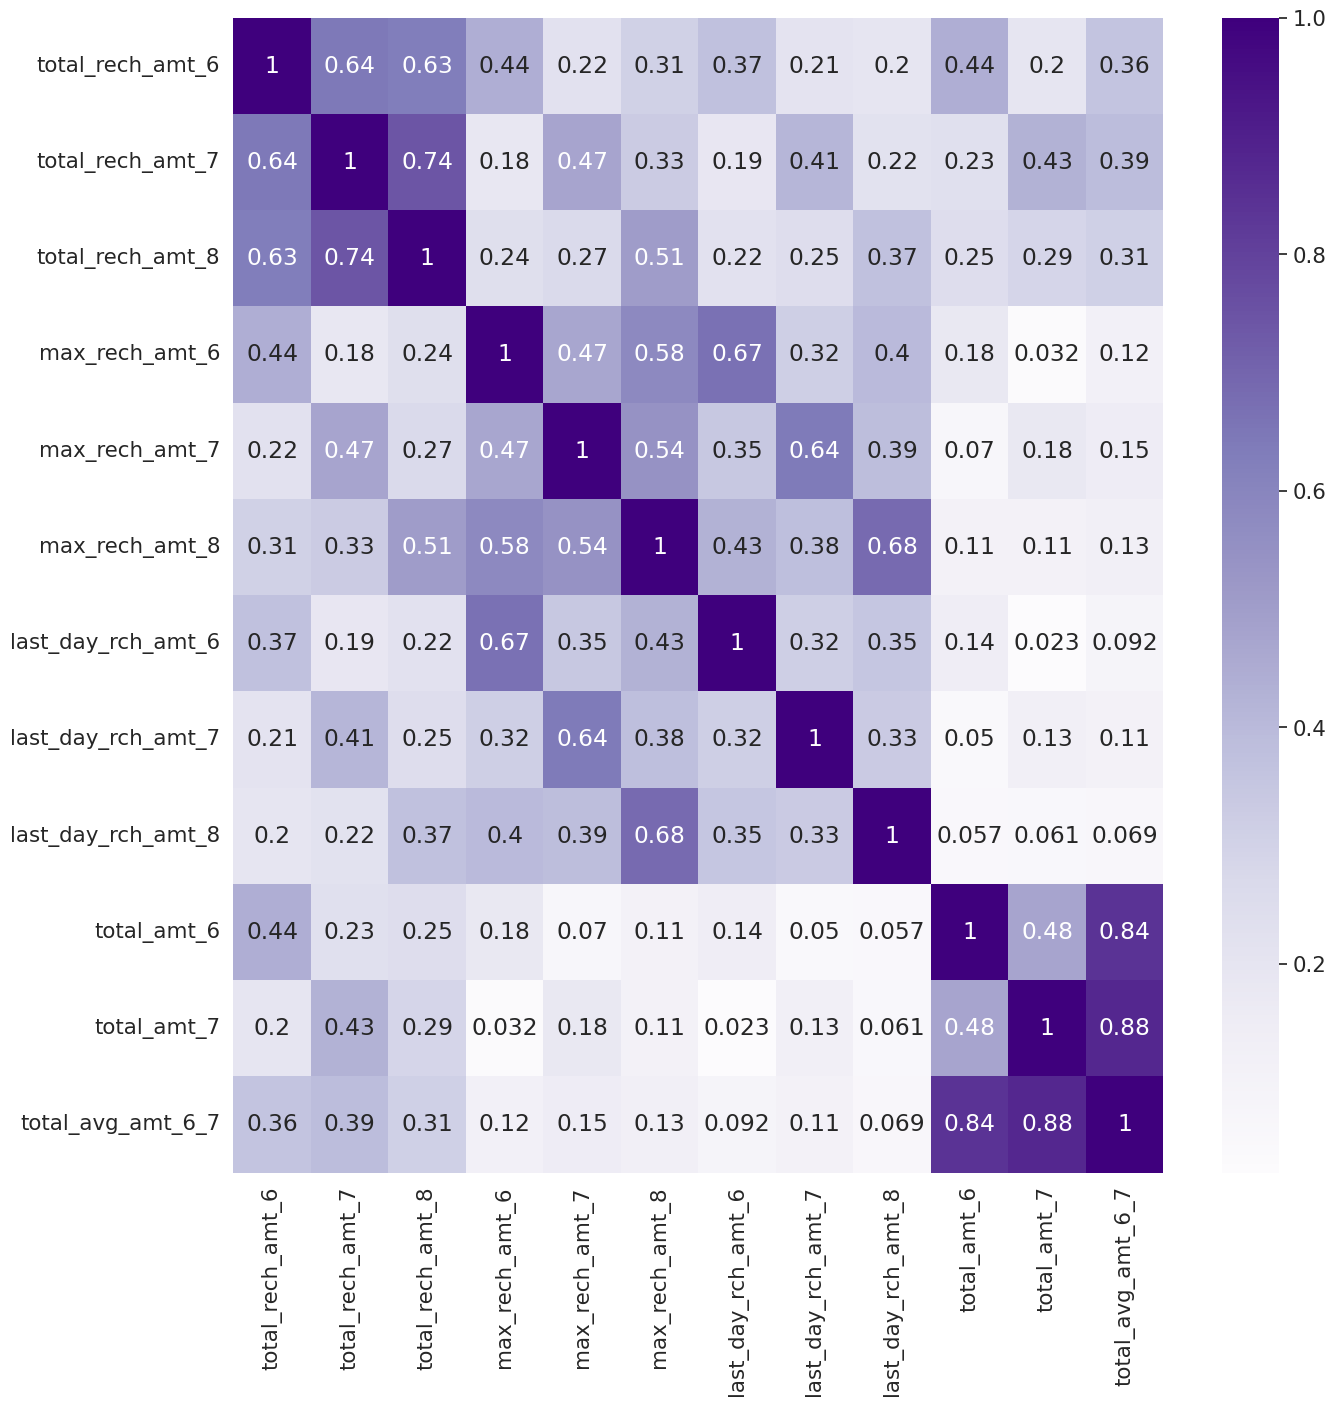

In [ ]:
amount_data = final_df.loc[:, final_df.columns.str.contains('amt')]
data2g = final_df.loc[:, final_df.columns.str.contains('2g')]
data3g = final_df.loc[:, final_df.columns.str.contains('3g')]
ic_mou_data = final_df.loc[:, final_df.columns.str.contains('ic') & final_df.columns.str.contains('mou')]
net_mou_data = final_df.loc[:, final_df.columns.str.contains('net_mou')]
og_mou_data = final_df.loc[:, final_df.columns.str.contains('og') & final_df.columns.str.contains('mou')]
rech_data = final_df.loc[:, final_df.columns.str.contains('rech')]
total_data = final_df.loc[:, final_df.columns.str.contains('tot')]
# Amount data
plt.figure(figsize=(15,15))
sns.heatmap(amount_data.corr(), annot=True, cmap='Purples')
plt.show()

Observations:

A **strong correlation** of 74% is observed between the total recharge amount in month 7 and the total recharge amount in month 8. This indicates a significant relationship between the recharge behavior across these two consecutive months.

There is a notable correlation of 68% between the maximum recharge amount in month 8 and the recharge amount on the last day of the same month. This suggests that higher maximum recharge amounts in month 8 are associated with higher recharge amounts on the final day of that month.



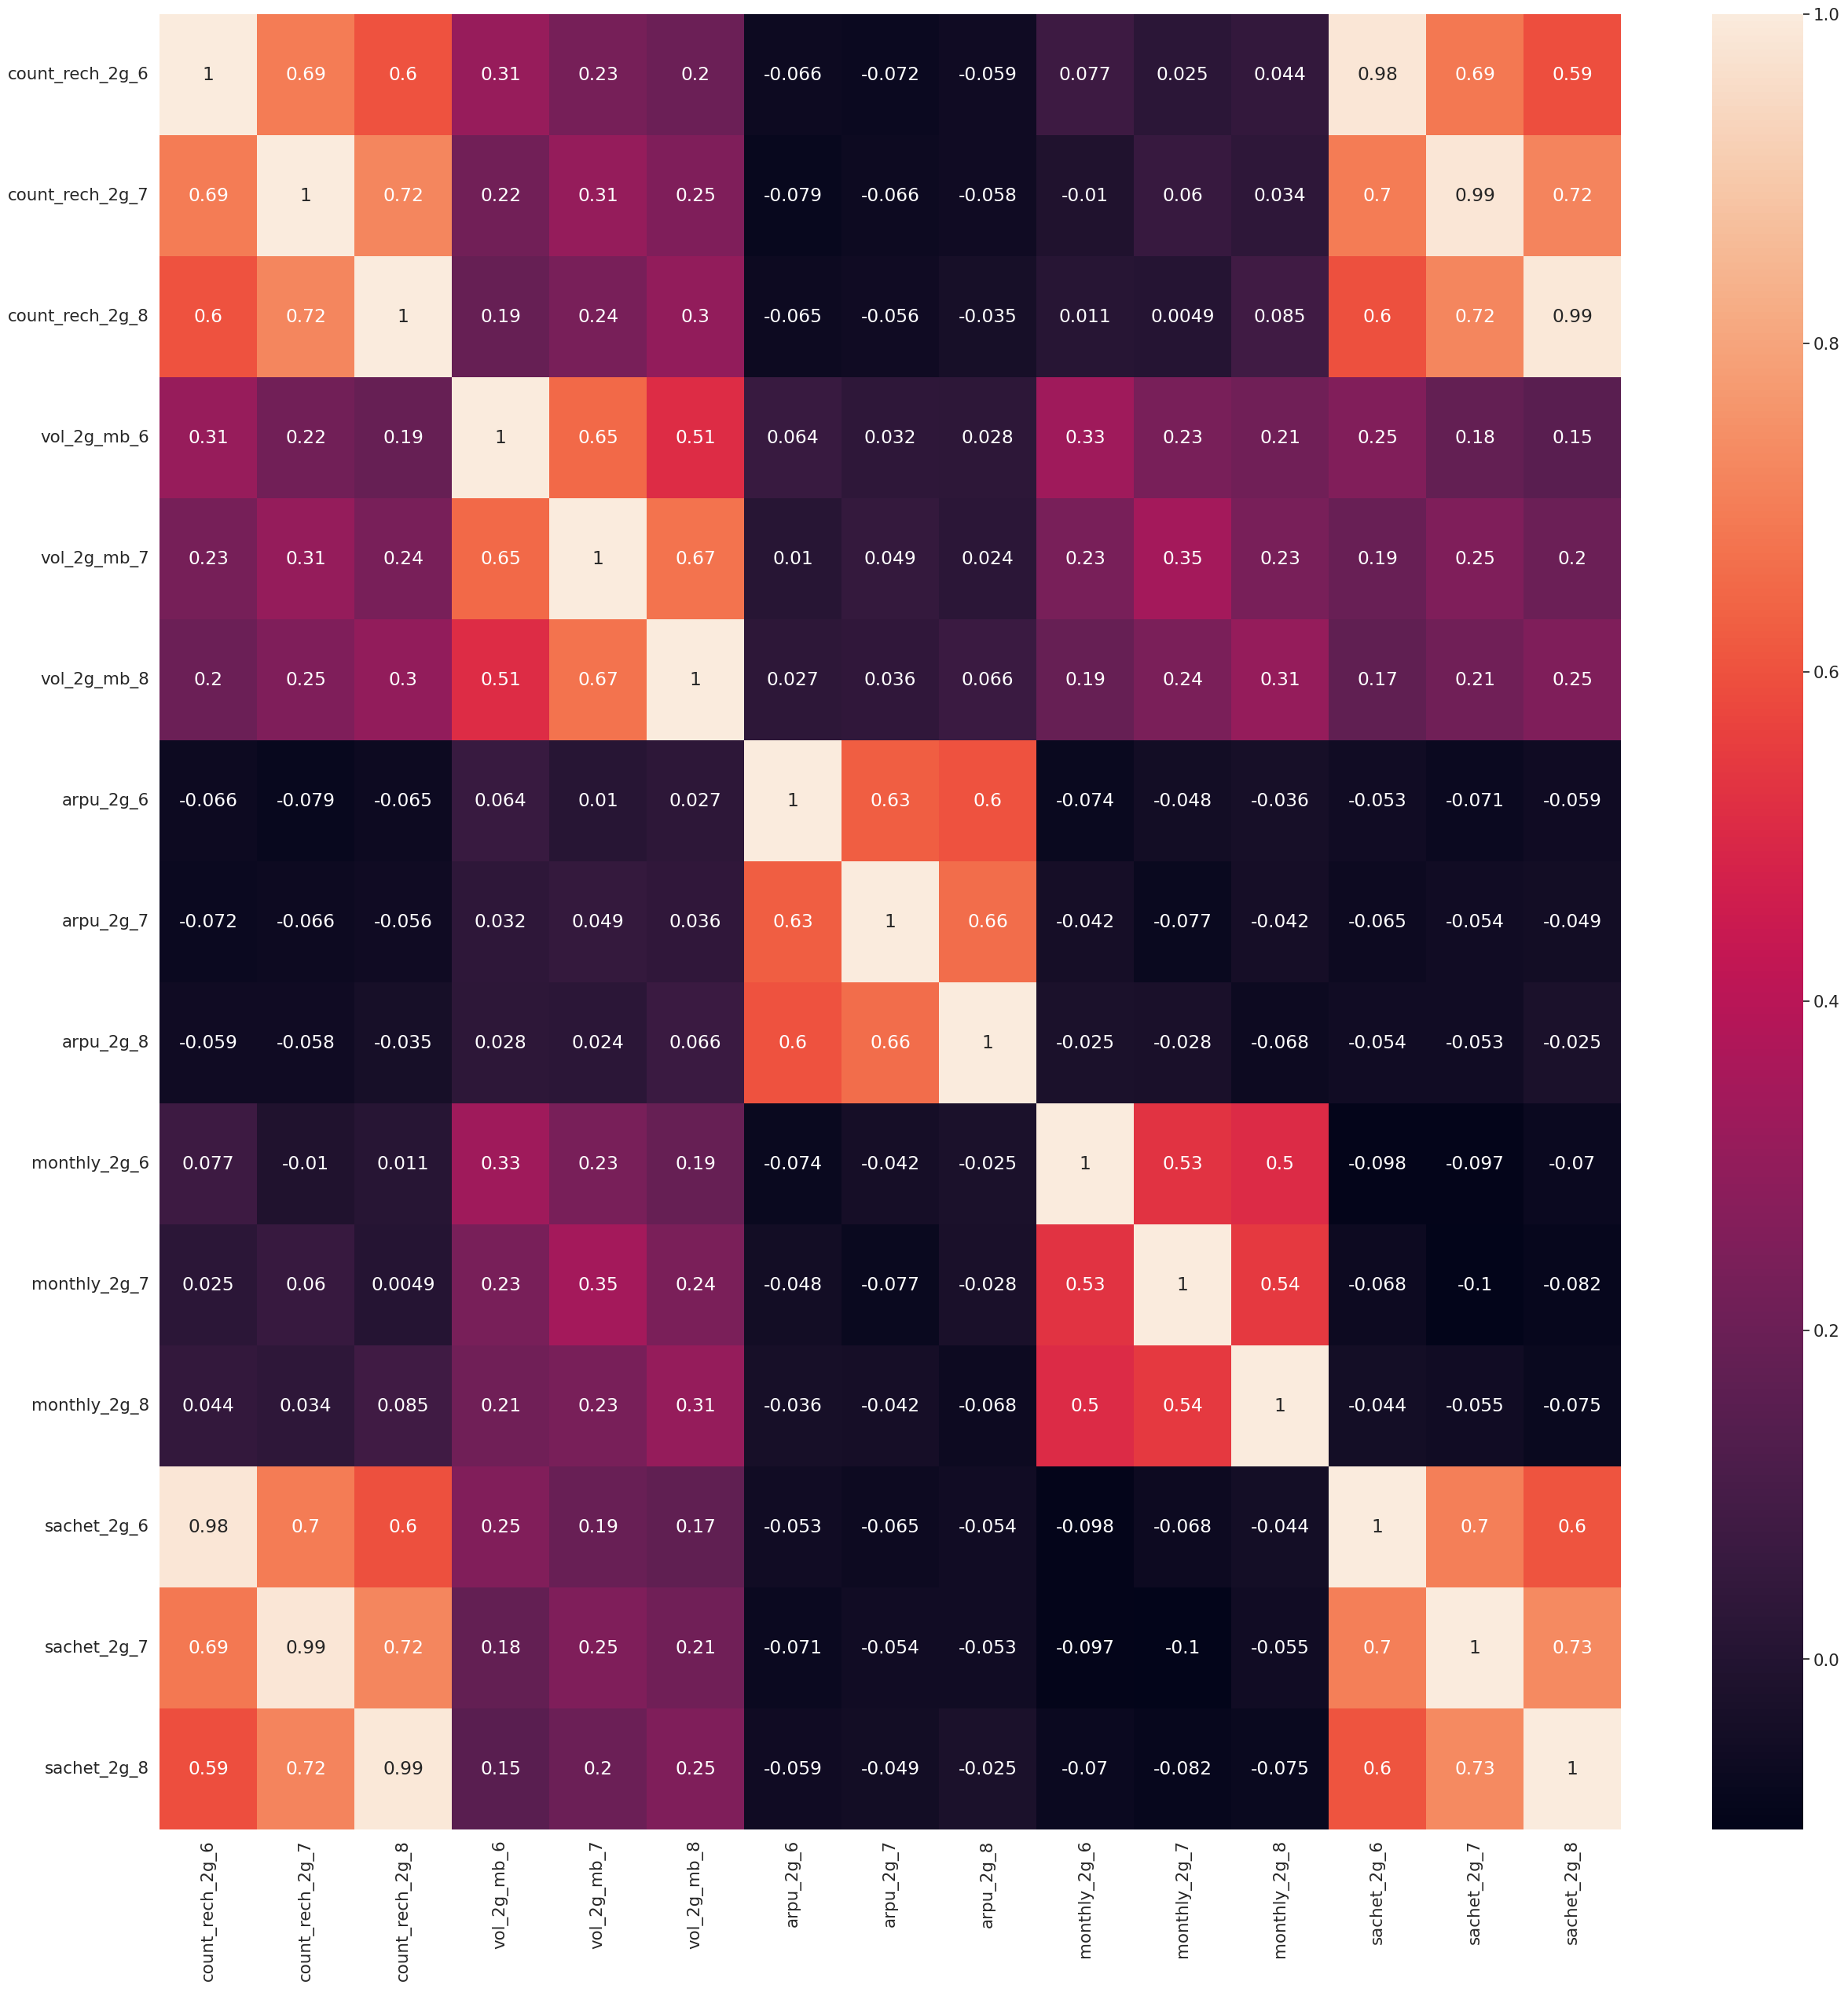

In [ ]:
# data2g plotting correlations
plt.figure(figsize=(30,30))
sns.heatmap(data2g.corr(), annot=True)
plt.show()

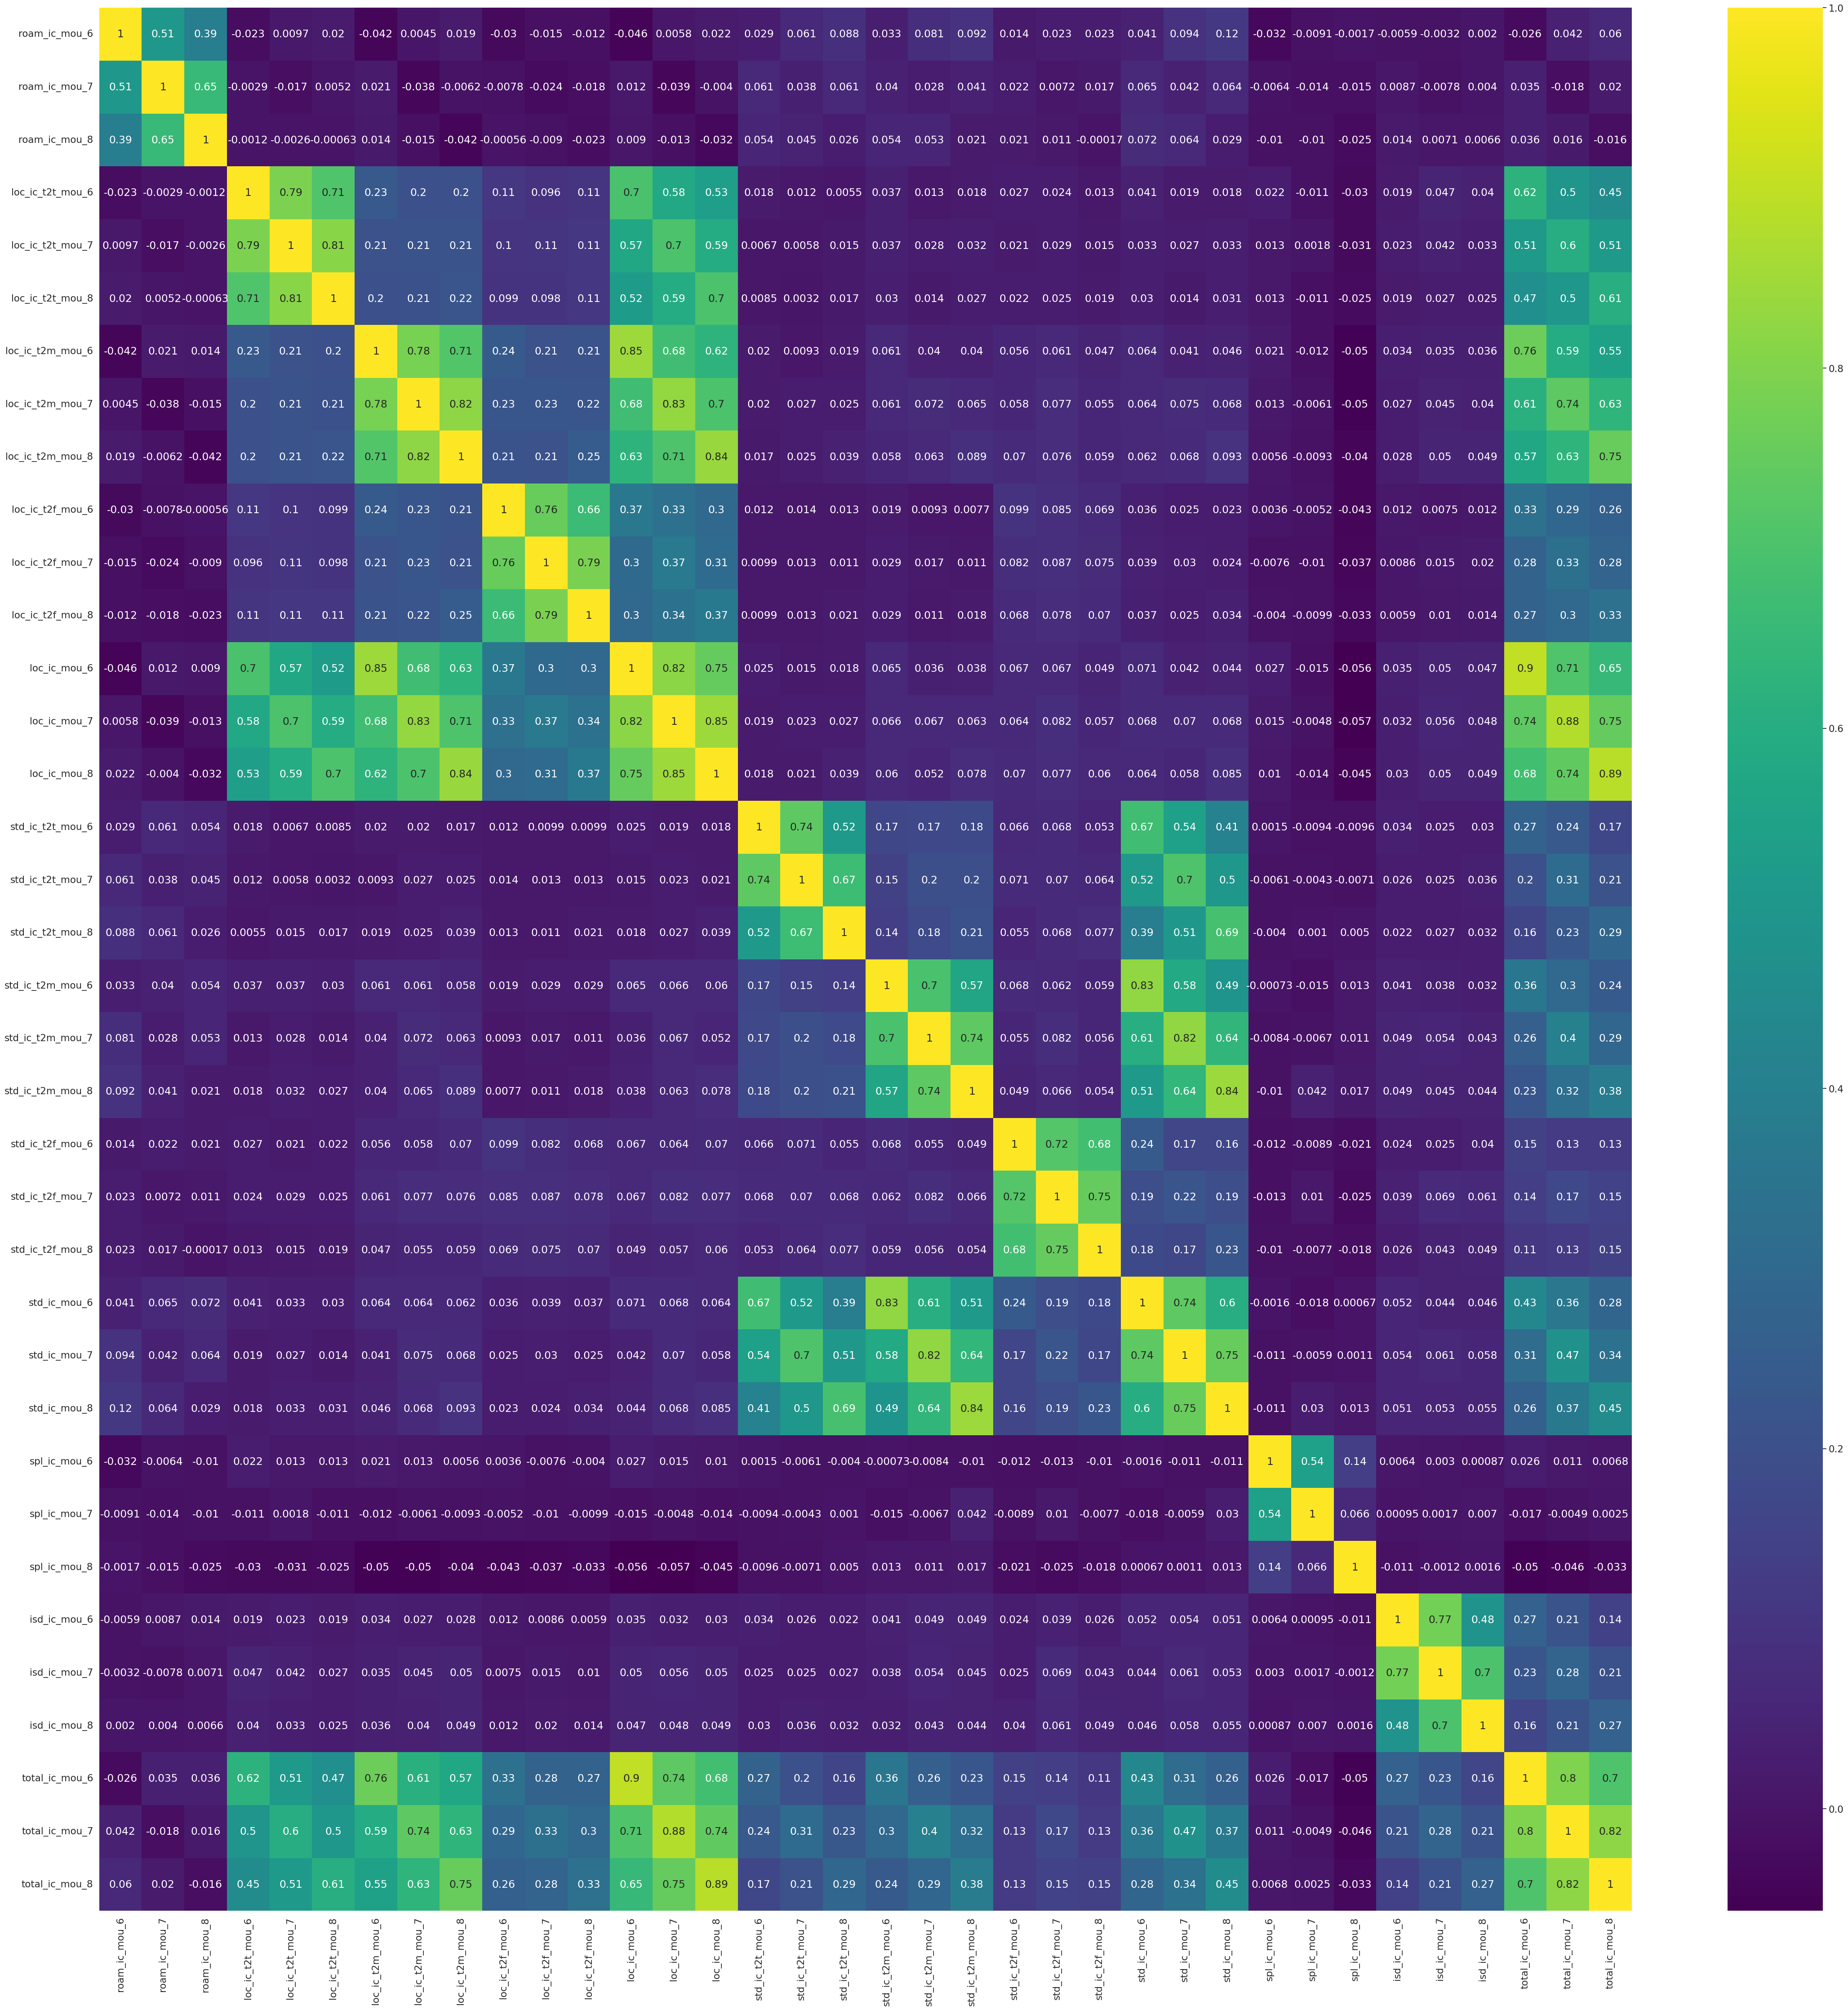

In [ ]:
#ic_mou_data
plt.figure(figsize=(55, 55))
sns.heatmap(ic_mou_data.corr(), annot=True, cmap='viridis')
plt.show()

high correlation noticed in the following:

1. total_ic_mou_6 and loc_ic_mou_6
2. total_ic_mou_7 and loc_ic_mou_7
3. total_ic_mou_8 and loc_ic_mou_8
4. std_ic_mou_6 and std_ic_t2f_mou_6
5. std_ic_mou_7 and std_ic_t2f_mou_7
6. std_ic_mou_8 and std_ic_t2f_mou_8




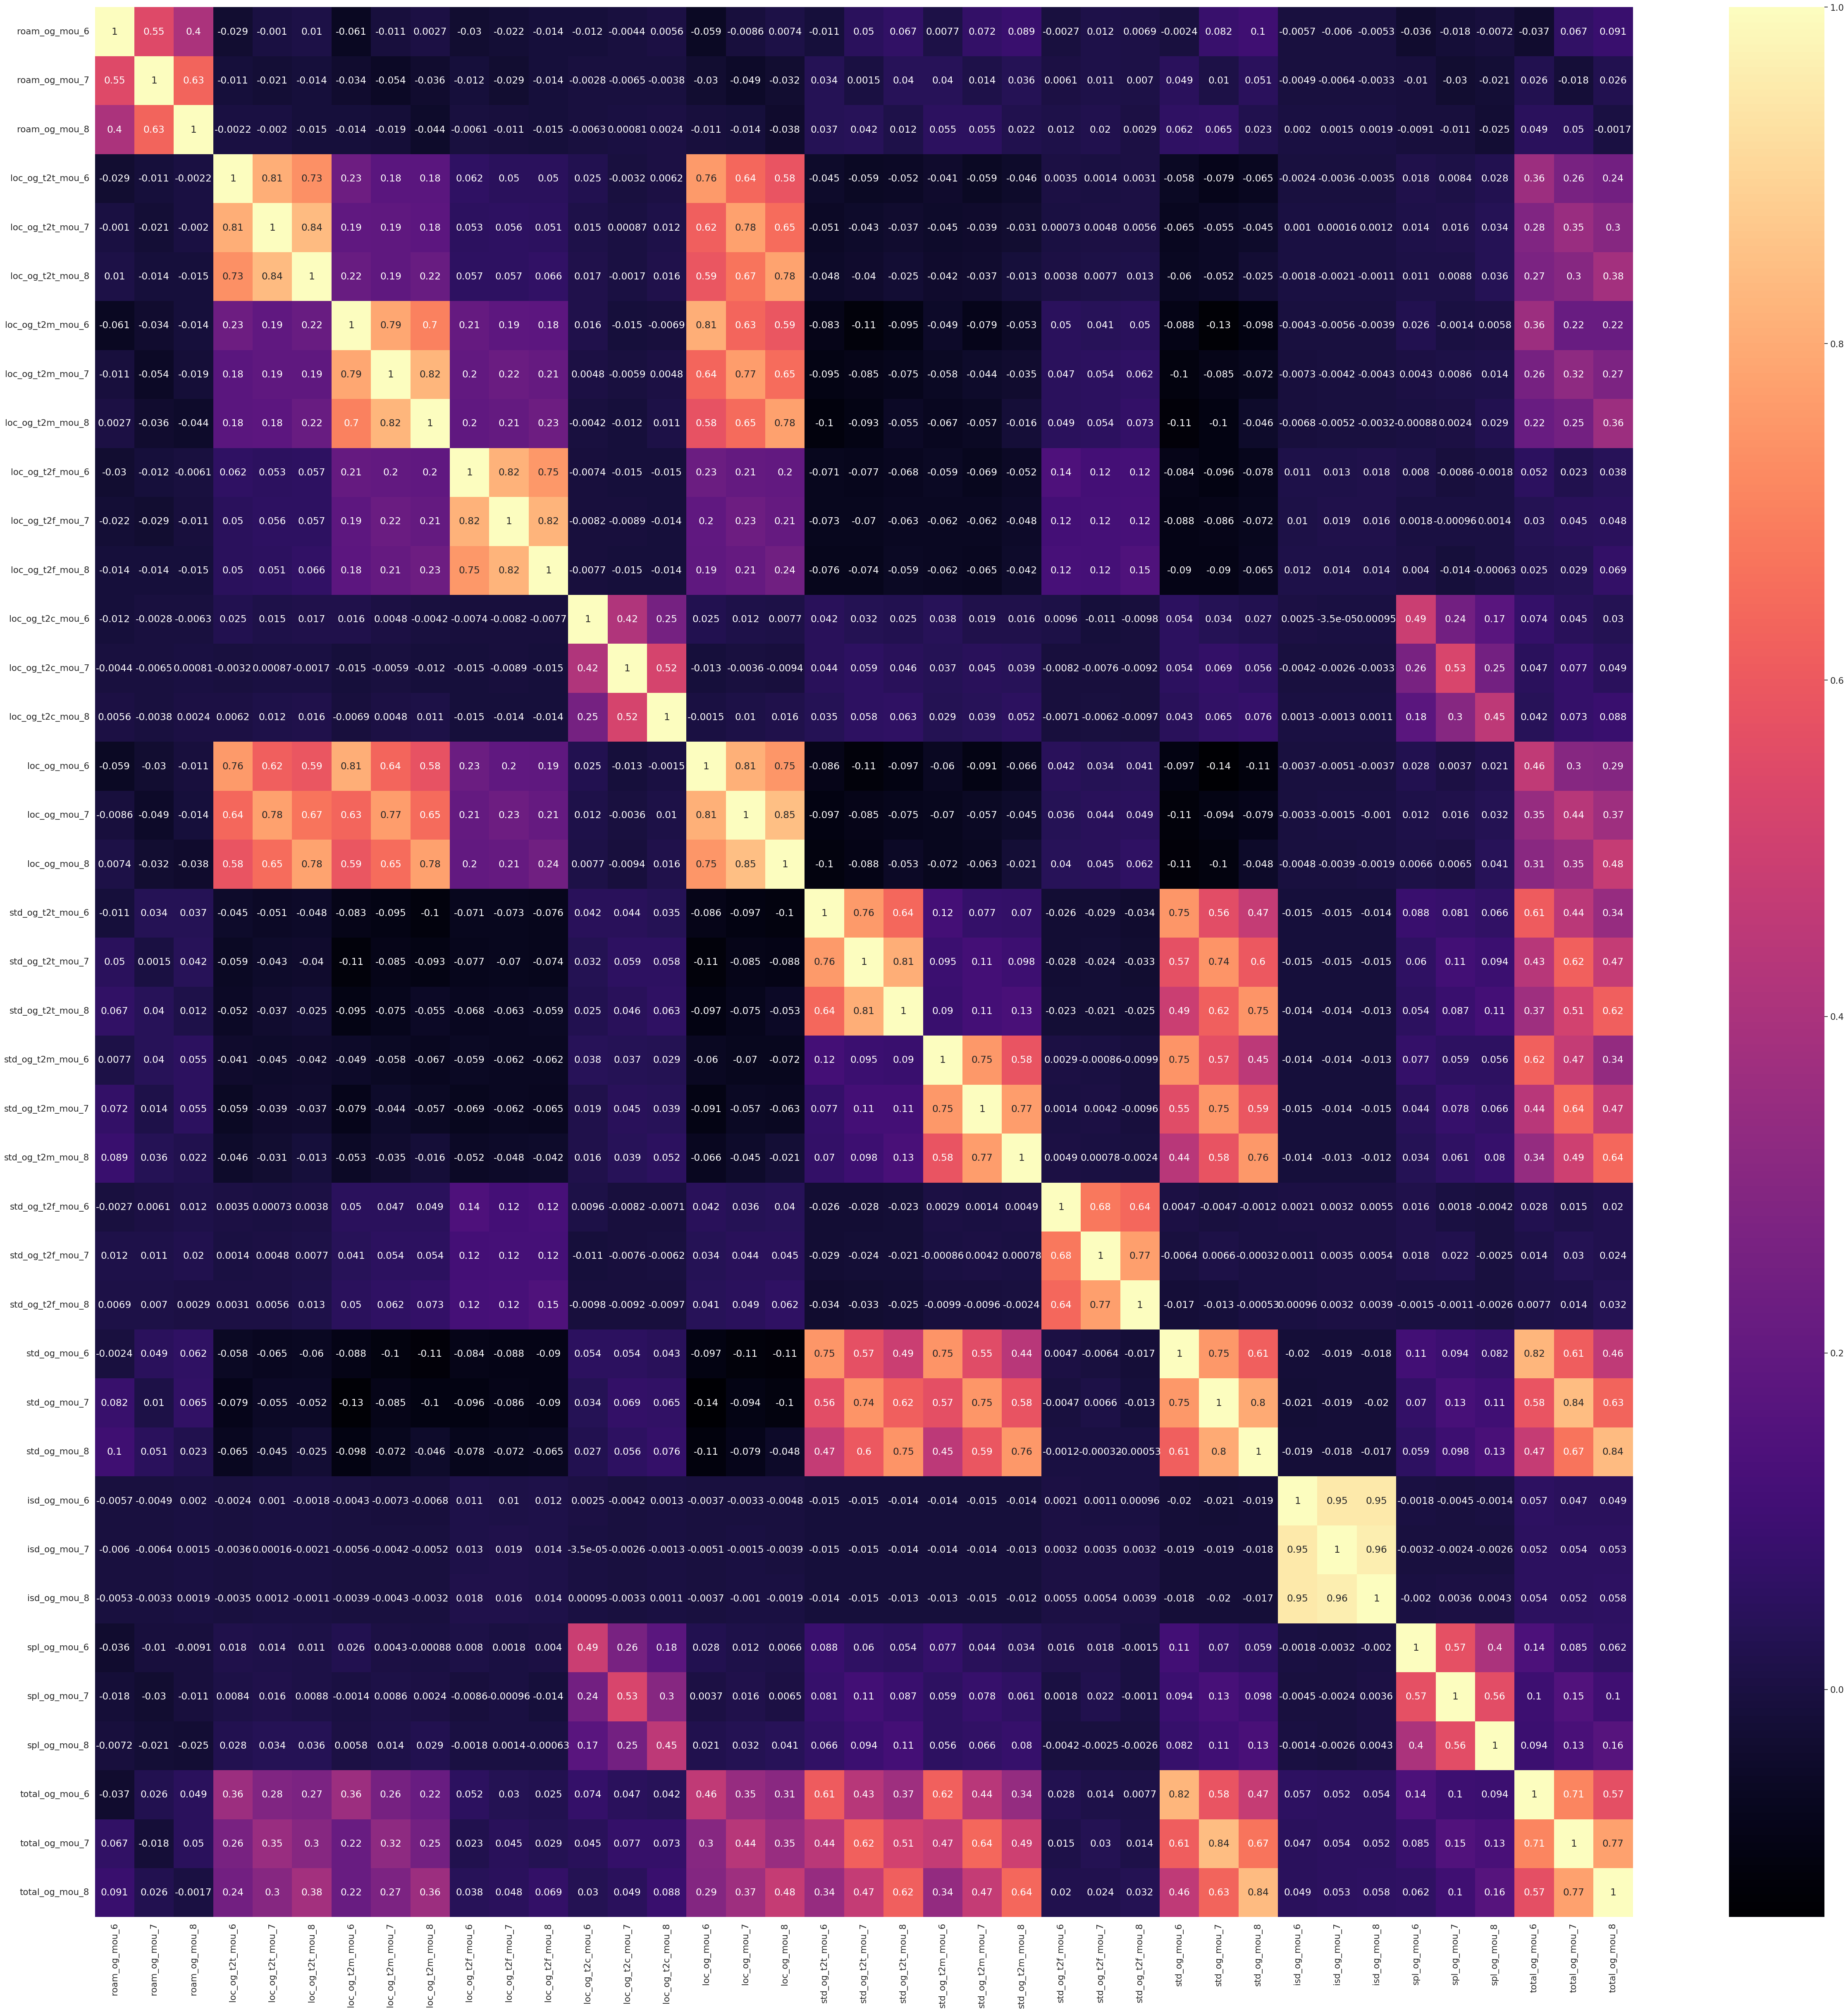

In [ ]:
#og_mou_data
plt.figure(figsize=(60,60))
sns.heatmap(og_mou_data.corr(), annot=True, cmap='magma')
plt.show()

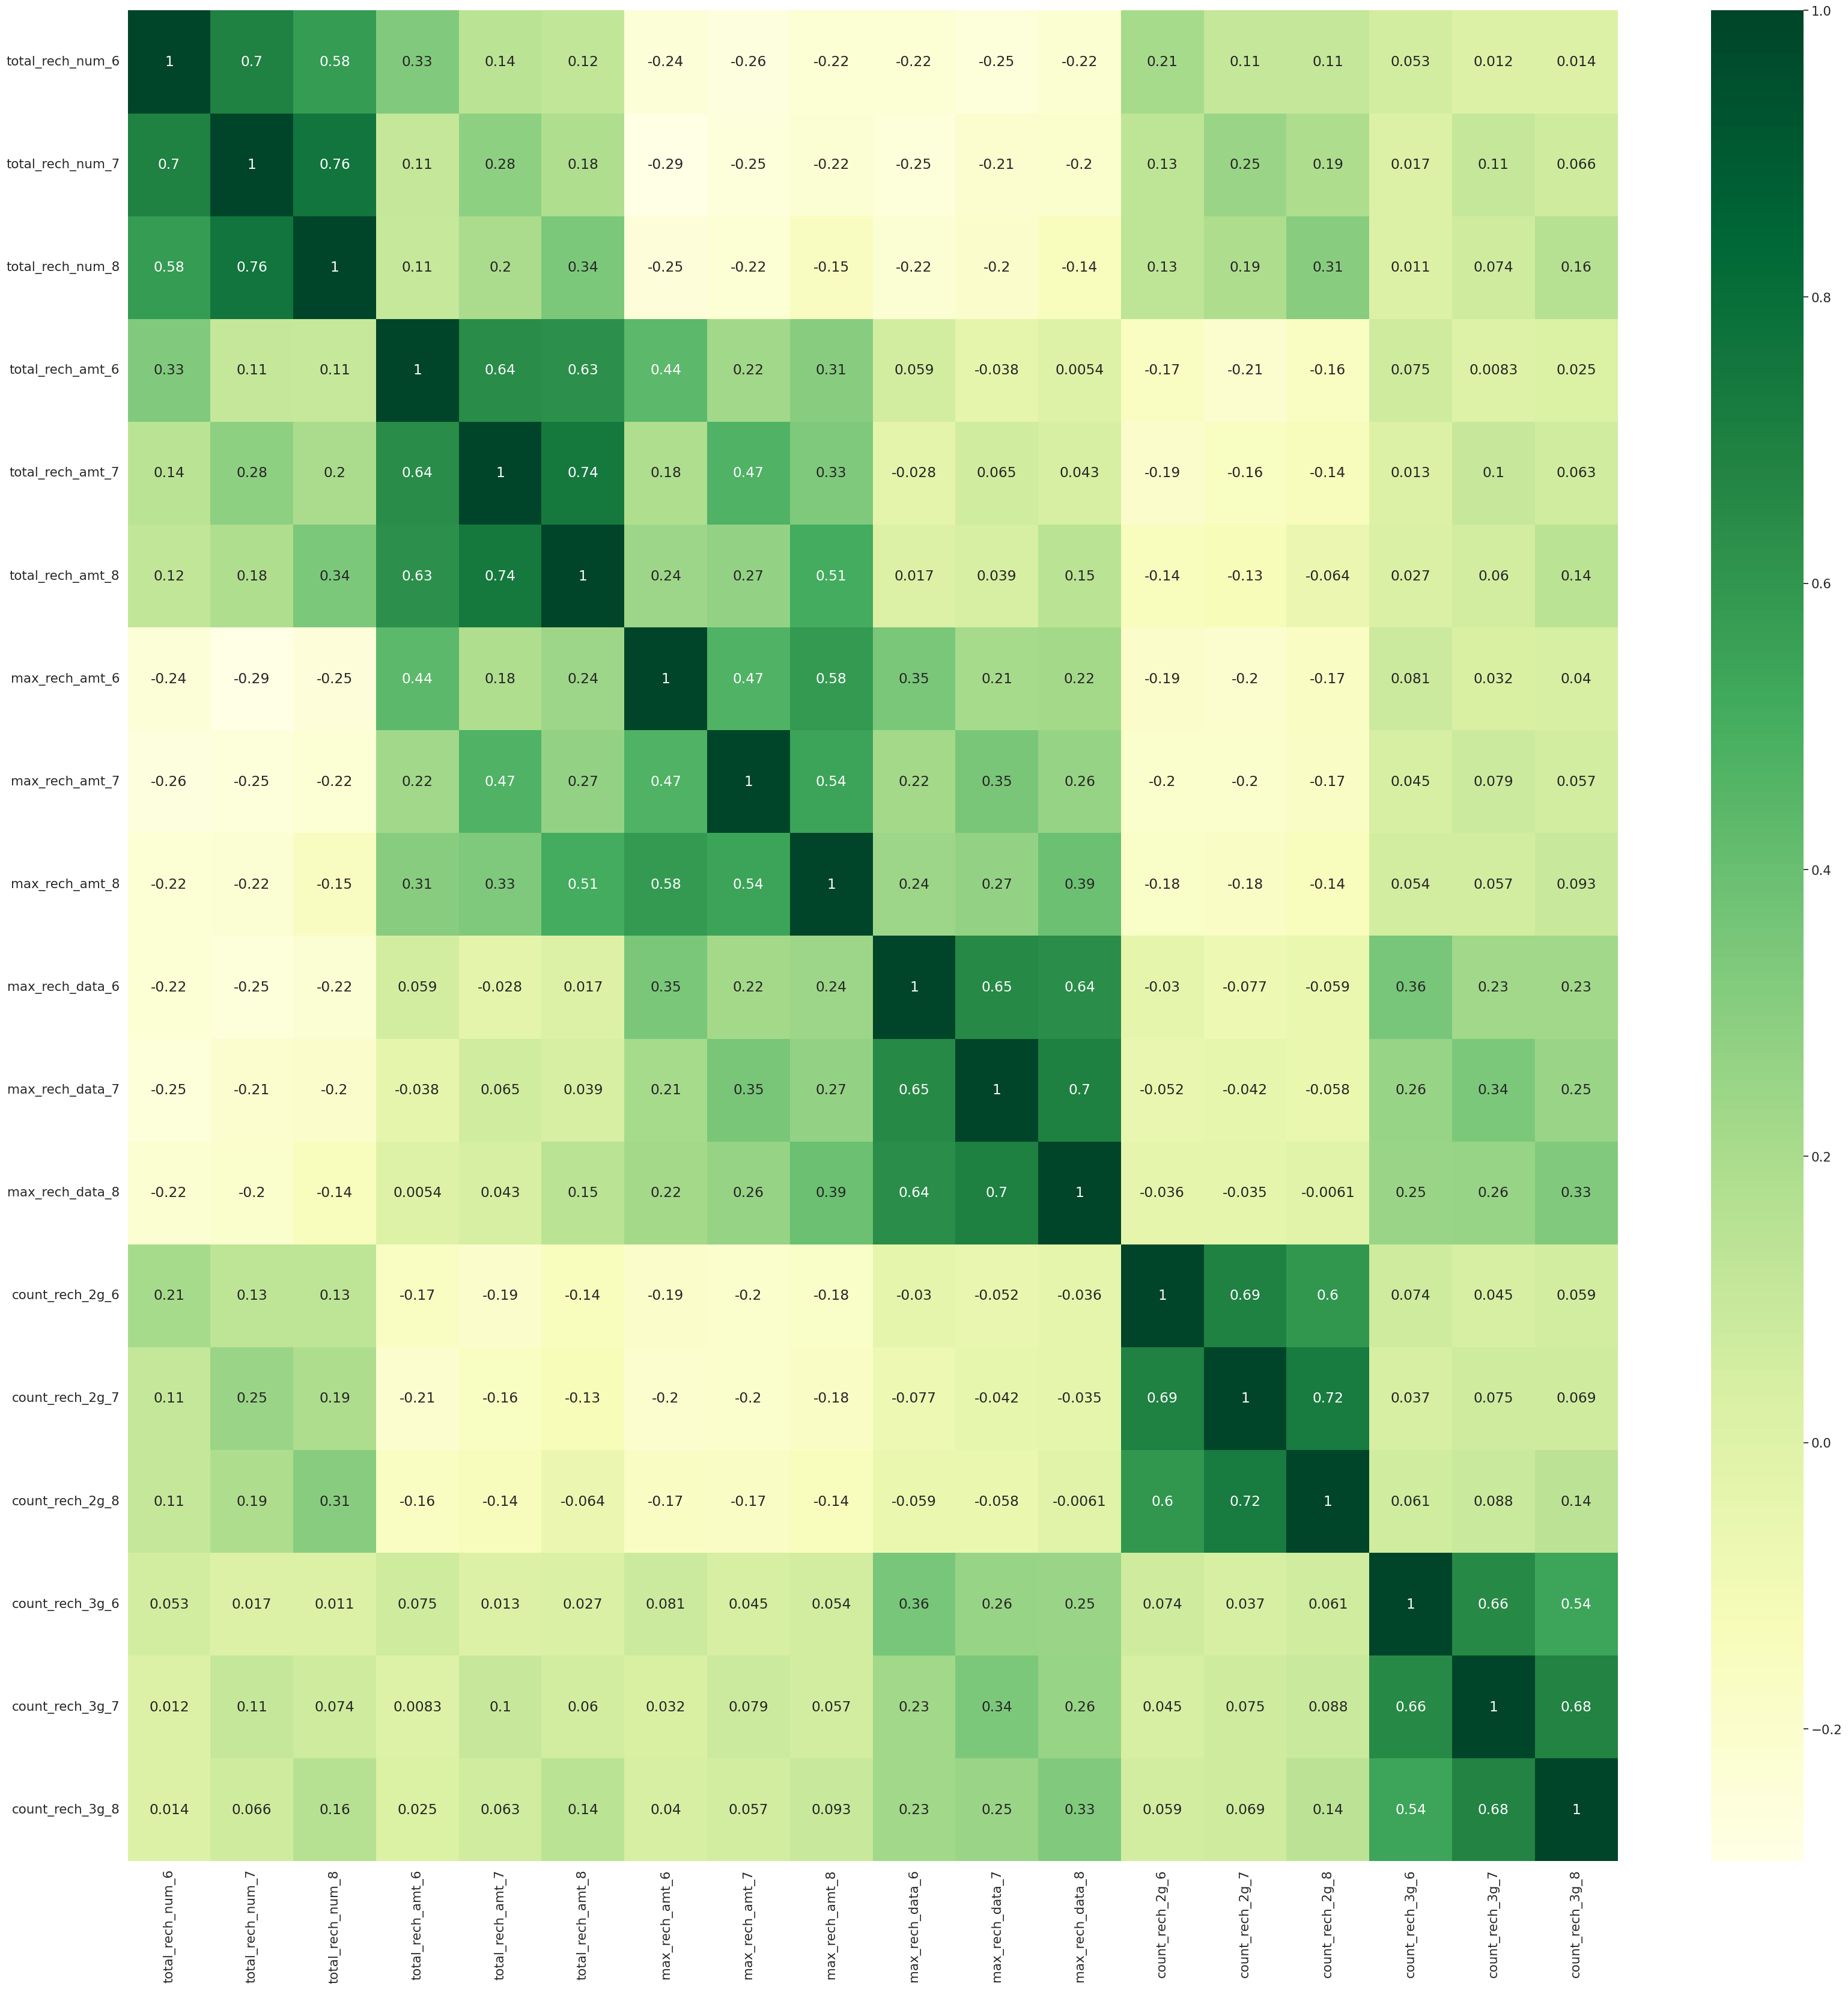

In [ ]:
#rech_data
plt.figure(figsize=(40,40))
sns.heatmap(rech_data.corr(), annot=True, cmap='YlGn')
plt.show()

There is a notably high correlation of 82% between the incoming minutes of usage in months 7 and 8, and a similarly high correlation of 77% between the outgoing minutes of usage in these two months. This indicates a strong relationship in usage patterns between these consecutive months.

The substantial usage patterns suggest that customers who consistently use a high amount of both incoming and outgoing minutes are less likely to churn.

## 4.Dummy Variable Encoding:

In [ ]:
dummy_df = pd.get_dummies(final_df[['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6']], drop_first=True, dtype='int')
final_df = pd.concat([final_df, dummy_df], axis=1)
# drop the category cols
final_df.drop(['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6'], axis=1, inplace=True)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20998 entries, 0 to 20997
Columns: 155 entries, onnet_mou_6 to night_pck_user_6_1.0
dtypes: category(1), float64(117), int64(37)
memory usage: 24.7 MB


In [ ]:
# Creating dummies for categorical columns
dummy_unseen_df = pd.get_dummies(final_unseen_df[['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6']], drop_first=True, dtype='int')
final_unseen_df = pd.concat([final_unseen_df, dummy_unseen_df], axis=1)
# drop the category cols
final_unseen_df.drop(['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6'], axis=1, inplace=True)
final_unseen_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 155 entries, onnet_mou_6 to night_pck_user_6_1.0
dtypes: float64(117), int64(38)
memory usage: 35.5 MB


In [ ]:
print(final_unseen_df.shape) ## testing
print(final_df.shape) ## training

(30000, 155)
(20998, 155)


##5.OutLiers

Applying outlier treatment helps create a cleaner dataset, which can lead to more robust and reliable models. It is particularly important for ensuring that your models generalize well and make accurate predictions.

In [ ]:
print(final_df.describe(percentiles=[.25, .50, .75, .90, .95, .99]))

# List of numerical columns
numerical_cols = list(final_df.select_dtypes(exclude='category'))

# Apply outlier handling to numerical columns directly
for col in numerical_cols:
    # Transform values based on specified conditions
    final_df[col] = final_df[col].apply(
        lambda value: 0 if value <= 0 else (1.5 if value == 1.0 else np.log1p(value))
    )

# Inspect numerical columns again after outlier handling
print(final_df.describe(percentiles=[.25, .50, .75, .90, .95, .99]))


        onnet_mou_6   onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  \
count  20998.000000  20998.000000  20998.000000  20998.000000  20998.000000   
mean     267.170793    272.100831    240.685694    382.262764    383.247937   
std      466.085572    486.515207    465.230750    480.518888    490.939567   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       19.440000     17.940000     13.815000     79.540000     75.790000   
50%       90.235000     87.830000     72.685000    234.680000    228.800000   
75%      292.127500    290.620000    245.405000    495.255000    498.790000   
90%      766.325000    788.211000    672.592000    912.390000    922.828000   
95%     1147.427500   1194.174500   1086.979500   1265.446000   1274.301500   
99%     2164.456000   2239.353000   2153.499100   2338.036700   2394.084300   
max     7376.710000   8157.780000  10752.560000   8362.360000   7043.980000   

       offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

iterative_imputer = IterativeImputer(max_iter=10, random_state=0)
df_imp_iterative = iterative_imputer.fit_transform(df_num)

In [ ]:
ids = ['id','circle_id']
total_amounts = [i for i in list(data.columns) if re.search('total.+amt',i)]
total_outgoing_minutes = [i for i in list(data.columns) if re.search('total.+og.+mou',i)]
offnetwork_minutes = [i for i in list(data.columns) if re.search('offnet',i)]
average_revenue_3g = [i for i in list(data.columns) if re.search('arpu.+3g',i)]
average_revenue_2g = [i for i in list(data.columns) if re.search('arpu.+2g',i)]
volume_3g = [i for i in list(data.columns) if re.search('vol.+3g',i)]
volume_2g = [i for i in list(data.columns) if re.search('vol.+2g',i)]
age_on_network = [i for i in list(data.columns) if re.search('aon',i)]



In [ ]:
#Storing them in a single flat list
variables = [*ids,
             *total_amounts,
             *total_outgoing_minutes,
             *offnetwork_minutes,
             *average_revenue_3g,
             *average_revenue_2g,
             *volume_3g,
             *volume_2g,
             *age_on_network,
             'churn_probability']


In [ ]:
data.head()

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0   31.277   87.009    7.527        48.58       124.38         1.29   
1    0.000  122.787   42.953         0.00         0.00         0.00   
2   60.806  103.176    0.000         0.53        15.93         0.00   
3  156.362  205.260  111.095         7.26        16.01         0.00   
4  240.708  128.191  101.565        21.28         4.83         6.13   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  ...  fb_user_7  \
0         32.24         96.68          2.33           0.00  ...       -1.0   
1          0.00         25.99         30.89           0.00  ...        1.0   
2         53.99         82.05          0.00           0.00  ...       -1.0   
3         68.76         78.48         50.23           0.00  ...       -1.0   
4         56.99         38.11          9.63          53.64  ...        1.0   

   fb_user_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  churn_probability  \
0       -1.0  1958         0.0         0.0         0.0                  0   
1       -1.0   710         0.0         0.0         0.0                  0   
2       -1.0   882         0.0         0.0         0.0                  0   
3       -1.0   982         0.0         0.0         0.0                  0   
4        1.0   647         0.0         0.0         0.0                  0   

   total_amt_6  total_amt_7  total_avg_amt_6_7  
0         77.0         65.0               71.0  
1          0.0        290.0              145.0  
2         70.0        120.0               95.0  
3        160.0        240.0              200.0  
4       1515.0       1473.0             1494.0  

[5 rows x 149 columns]

In [ ]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 149 columns):
 #    Column              Dtype   
---   ------              -----   
 0    arpu_6              float64 
 1    arpu_7              float64 
 2    arpu_8              float64 
 3    onnet_mou_6         float64 
 4    onnet_mou_7         float64 
 5    onnet_mou_8         float64 
 6    offnet_mou_6        float64 
 7    offnet_mou_7        float64 
 8    offnet_mou_8        float64 
 9    roam_ic_mou_6       float64 
 10   roam_ic_mou_7       float64 
 11   roam_ic_mou_8       float64 
 12   roam_og_mou_6       float64 
 13   roam_og_mou_7       float64 
 14   roam_og_mou_8       float64 
 15   loc_og_t2t_mou_6    float64 
 16   loc_og_t2t_mou_7    float64 
 17   loc_og_t2t_mou_8    float64 
 18   loc_og_t2m_mou_6    float64 
 19   loc_og_t2m_mou_7    float64 
 20   loc_og_t2m_mou_8    float64 
 21   loc_og_t2f_mou_6    float64 
 22   loc_og_t2f_mou_7    float64 
 23   loc_og_t2

## 6.Model Building



###6.1 train test split

In [ ]:

# Partitioning the dataset into the feature variable 'X' and the response variable 'y'.
X = final_df.drop(['churn_probability'], axis=1)
y = final_df['churn_probability']

In [ ]:
# Train test split - 80% training data, 20% validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=100)
# Checking the shape after split
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_val Shape:', X_val.shape)
print('y_val Shape:', y_val.shape)


X_train Shape: (16798, 154)
y_train Shape: (16798,)
X_val Shape: (4200, 154)
y_val Shape: (4200,)


###6.2 handling imbalance

In [ ]:

smt = SMOTE(random_state=2)
X_train_smote, y_train_smote = smt.fit_resample(X_train, y_train)

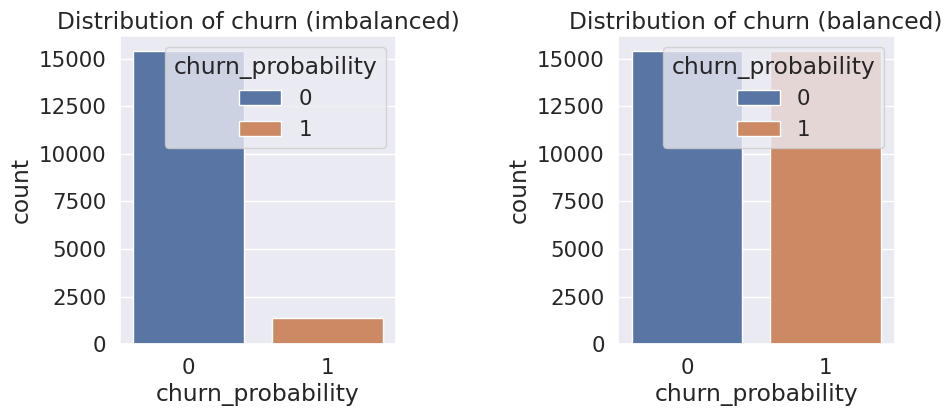

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.title("Distribution of churn (imbalanced)")
sns.countplot(x=y_train, hue=y_train)

plt.subplot(1,2,2)
plt.title("Distribution of churn (balanced)")
sns.countplot(x=y_train_smote, hue=y_train_smote)

plt.subplots_adjust(wspace=0.8)
plt.show()

In [ ]:
print(X_train_smote.shape)
print(y_train_smote.shape)

(30800, 154)
(30800,)


### 6.3 Feature Scaling

In [ ]:
# Use SandardScaler to scale values
scaler = StandardScaler()

# Fit and transform training set
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_smote), columns = X_train_smote.columns, index = X_train_smote.index)

# Only Transform validation set
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns = X_val.columns, index = X_val.index)

In [ ]:
X_train_scaled.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0     0.149097     0.096313     0.612506     -0.131917     -0.127232   
1    -0.011491     0.097480     0.221881     -0.168733     -0.384974   
2     1.347333     1.161160     1.273533     -0.123081     -0.561949   
3     0.575350     0.440487     0.779006      1.168985      1.270926   
4     1.177194     1.567885     1.767955      0.643104     -0.114263   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0      0.241259       2.442332      -0.530507       2.266093       2.179343   
1      0.112299       0.953739      -0.530507       1.403829       1.516741   
2     -0.429040      -0.527310      -0.530507      -0.665387      -0.547857   
3      1.305694      -0.527310      -0.530507      -0.665387      -0.547857   
4      0.279905      -0.527310      -0.530507      -0.665387      -0.547857   

   ...  fb_user_8_0.0  fb_user_8_1.0  fb_user_7_0.0  fb_user_7_1.0  \
0  ...      -0.246405       1.498577      -0.209151      -0.882333   
1  ...      -0.246405      -0.683643      -0.209151      -0.882333   
2  ...      -0.246405      -0.683643      -0.209151      -0.882333   
3  ...      -0.246405       1.498577      -0.209151       1.162058   
4  ...      -0.246405       1.498577      -0.209151       1.162058   

   fb_user_6_0.0  fb_user_6_1.0  night_pck_user_7_0.0  night_pck_user_7_1.0  \
0      -0.208259       1.083555             -0.936624             -0.109314   
1      -0.208259      -0.946637             -0.936624             -0.109314   
2      -0.208259      -0.946637             -0.936624             -0.109314   
3      -0.208259       1.083555              1.104365             -0.109314   
4      -0.208259       1.083555             -0.936624             10.125927   

   night_pck_user_6_0.0  night_pck_user_6_1.0  
0              1.043735             -0.133862  
1             -0.998620             -0.133862  
2             -0.998620             -0.133862  
3              1.043735             -0.133862  
4             -0.998620              8.908799  

[5 rows x 154 columns]

In [ ]:
final_unseen_df.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0        31.78        20.23        23.11         60.16         32.16   
1        75.51        41.21        19.84        474.34        621.84   
2         7.54         7.86         8.40         16.98         45.81   
3         5.31         2.16         0.00         40.04        205.01   
4       450.93       609.03       700.68         60.94         23.84   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0         34.83           0.00           0.00           0.00           0.00   
1        394.94           0.00           0.00           0.00           0.00   
2         45.04          22.81         103.38          26.08          24.53   
3         24.01           0.00           0.00           0.00           0.00   
4         74.16           0.00           0.00           0.00           0.00   

   ...  fb_user_8_0.0  fb_user_8_1.0  fb_user_7_0.0  fb_user_7_1.0  \
0  ...              0              0              0              0   
1  ...              0              0              0              0   
2  ...              0              0              0              0   
3  ...              0              0              0              0   
4  ...              0              0              0              0   

   fb_user_6_0.0  fb_user_6_1.0  night_pck_user_7_0.0  night_pck_user_7_1.0  \
0              0              0                     0                     0   
1              0              0                     0                     0   
2              0              0                     0                     0   
3              0              0                     0                     0   
4              0              0                     0                     0   

   night_pck_user_6_0.0  night_pck_user_6_1.0  
0                     0                     0  
1                     0                     0  
2                     0                     0  
3                     0                     0  
4                     0                     0  

[5 rows x 155 columns]

In [ ]:
final_unseen_df.set_index('id', inplace=True)

###6.4 Logistic AND REF


In [ ]:
%%time
# Select top 20 features using RFE
logreg = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
rfe = RFE(logreg, n_features_to_select=20)
rfe = rfe.fit(X_train_scaled, y_train_smote)

CPU times: user 11min 17s, sys: 910 ms, total: 11min 18s
Wall time: 11min 23s


In [ ]:
list(zip(X_train_scaled.columns, rfe.support_, rfe.ranking_))

[('onnet_mou_6', False, 59),
 ('onnet_mou_7', False, 26),
 ('onnet_mou_8', False, 25),
 ('offnet_mou_6', False, 92),
 ('offnet_mou_7', False, 16),
 ('offnet_mou_8', False, 13),
 ('roam_ic_mou_6', False, 69),
 ('roam_ic_mou_7', False, 34),
 ('roam_ic_mou_8', True, 1),
 ('roam_og_mou_6', False, 68),
 ('roam_og_mou_7', False, 28),
 ('roam_og_mou_8', True, 1),
 ('loc_og_t2t_mou_6', False, 94),
 ('loc_og_t2t_mou_7', False, 66),
 ('loc_og_t2t_mou_8', False, 74),
 ('loc_og_t2m_mou_6', False, 22),
 ('loc_og_t2m_mou_7', False, 36),
 ('loc_og_t2m_mou_8', False, 23),
 ('loc_og_t2f_mou_6', False, 119),
 ('loc_og_t2f_mou_7', False, 38),
 ('loc_og_t2f_mou_8', False, 37),
 ('loc_og_t2c_mou_6', False, 79),
 ('loc_og_t2c_mou_7', False, 129),
 ('loc_og_t2c_mou_8', False, 109),
 ('loc_og_mou_6', False, 21),
 ('loc_og_mou_7', False, 15),
 ('loc_og_mou_8', False, 14),
 ('std_og_t2t_mou_6', False, 32),
 ('std_og_t2t_mou_7', False, 27),
 ('std_og_t2t_mou_8', False, 24),
 ('std_og_t2m_mou_6', False, 33),
 ('s

In [ ]:
# Selected features using RFE
selected_features = X_train_scaled.columns[rfe.support_]
selected_features

Index(['roam_ic_mou_8', 'roam_og_mou_8', 'loc_ic_t2t_mou_7',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8',
       'loc_ic_mou_7', 'loc_ic_mou_8', 'spl_ic_mou_8', 'total_ic_mou_8',
       'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6',
       'total_rech_amt_8', 'max_rech_amt_6', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'max_rech_data_8', 'count_rech_2g_8',
       'night_pck_user_8_0.0'],
      dtype='object')

In [ ]:
X_train_scaled_final = X_train_scaled[selected_features]
logreg.fit(X_train_scaled_final, y_train_smote)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [ ]:
y_train_smote_pred = logreg.predict(X_train_scaled_final)

In [ ]:

# Confusion matrix
cm = confusion_matrix(y_train_smote, y_train_smote)
print('Confusion Matrix')
print()
print(cm)

# True Positives, False Positives, True Negatives, False Negatives
TP = cm[1, 1]
FP = cm[0, 1]
TN = cm[0, 0]
FN = cm[1, 0]

# Accuracy Score
accuracy = round((TP + TN) / (TP + FP + TN + FN), 4)

# Sensitivity (Recall or True Positive Rate)
sensitivity = round(TP / (TP + FN), 4)

# Specificity
specificity = round(TN / (TN + FP), 4)

# Precision
precision = round(TP / (TP + FP), 4)

# False Positive Rate
false_positive_rate = round(FP / (FP + TN), 4)

# True Positive Rate
true_positive_rate = sensitivity

# Create DataFrame with metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'False Positive Rate', 'True Positive Rate'],
    'Value': [accuracy, sensitivity, specificity, precision, false_positive_rate, true_positive_rate]
})

# Print metrics DataFrame
print(metrics_df)

Confusion Matrix

[[15400     0]
 [    0 15400]]
                Metric  Value
0             Accuracy    1.0
1          Sensitivity    1.0
2          Specificity    1.0
3            Precision    1.0
4  False Positive Rate    0.0
5   True Positive Rate    1.0


In [ ]:
# Retain only the selected feature from the final model
X_val_scaled_final = X_val_scaled[selected_features]
X_val_scaled_final.head()

roam_ic_mou_8  roam_og_mou_8  loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  \
3837       -0.665387      -0.710456         -0.630131         -0.290168   
11055      -0.665387      -0.710456         -1.797907         -1.503523   
12221      -0.665387      -0.710456         -0.936458          0.500096   
17179       0.507003       0.310656         -1.797907         -1.503523   
16047      -0.665387      -0.710456          1.009888          1.293739   

       loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  loc_ic_mou_7  loc_ic_mou_8  \
3837          -1.557462         -0.780535     -1.260499     -0.619060   
11055         -2.375158         -1.877587     -2.594398     -1.984767   
12221         -1.291162         -0.008022     -1.288229      0.116259   
17179         -2.375158         -1.877587     -2.594398     -1.984767   
16047          0.136627          0.558739      0.498659      0.815106   

       spl_ic_mou_8  total_ic_mou_8  total_rech_num_7  total_rech_num_8  \
3837      -0.266206       -0.300154         -1.082799         -0.101475   
11055      2.474225       -1.317514         -1.434322         -0.619858   
12221      6.933130        0.329095          0.159277          1.437791   
17179     -0.266206       -1.395256          0.159277         -0.101475   
16047     -0.266206        0.859190         -1.887514         -0.987657   

       total_rech_amt_6  total_rech_amt_8  max_rech_amt_6  max_rech_amt_8  \
3837           0.204074          0.547510        0.794832        0.902878   
11055          0.035264          0.561889        0.794832        0.902878   
12221         -5.086412          0.669800       -4.510459        0.156583   
17179          0.347429         -0.539241        0.004934       -0.256881   
16047          0.431105         -1.678770        1.078205       -1.675565   

       last_day_rch_amt_8  max_rech_data_8  count_rech_2g_8  \
3837            -1.039975         1.790895        -0.595224   
11055           -1.039975         1.790895        -0.595224   
12221            0.724532        -0.735593        -0.595224   
17179           -1.039975        -0.735593        -0.595224   
16047           -1.039975        -0.735593        -0.595224   

       night_pck_user_8_0.0  
3837               1.363391  
11055              1.363391  
12221             -0.759323  
17179             -0.759323  
16047             -0.759323

In [ ]:
# Get the predicted values from the linear model
y_val_pred = logreg.predict(X_val_scaled_final)
confusion = confusion_matrix(y_true=y_val, y_pred=y_val_pred)
print(confusion)

[[3379  484]
 [  76  261]]


In [ ]:

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
print('Confusion Matrix')
print()
print(cm)

# True Positives, False Positives, True Negatives, False Negatives
TP = cm[1, 1]
FP = cm[0, 1]
TN = cm[0, 0]
FN = cm[1, 0]

# Accuracy Score
accuracy = round((TP + TN) / (TP + FP + TN + FN), 4)

# Sensitivity (Recall or True Positive Rate)
sensitivity = round(TP / (TP + FN), 4)

# Specificity
specificity = round(TN / (TN + FP), 4)

# Precision
precision = round(TP / (TP + FP), 4)

# False Positive Rate
false_positive_rate = round(FP / (FP + TN), 4)

# True Positive Rate
true_positive_rate = sensitivity

# Create DataFrame with metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'False Positive Rate', 'True Positive Rate'],
    'Value': [accuracy, sensitivity, specificity, precision, false_positive_rate, true_positive_rate]
})

# Print metrics DataFrame
print(metrics_df)

Confusion Matrix

[[3379  484]
 [  76  261]]
                Metric   Value
0             Accuracy  0.8667
1          Sensitivity  0.7745
2          Specificity  0.8747
3            Precision  0.3503
4  False Positive Rate  0.1253
5   True Positive Rate  0.7745


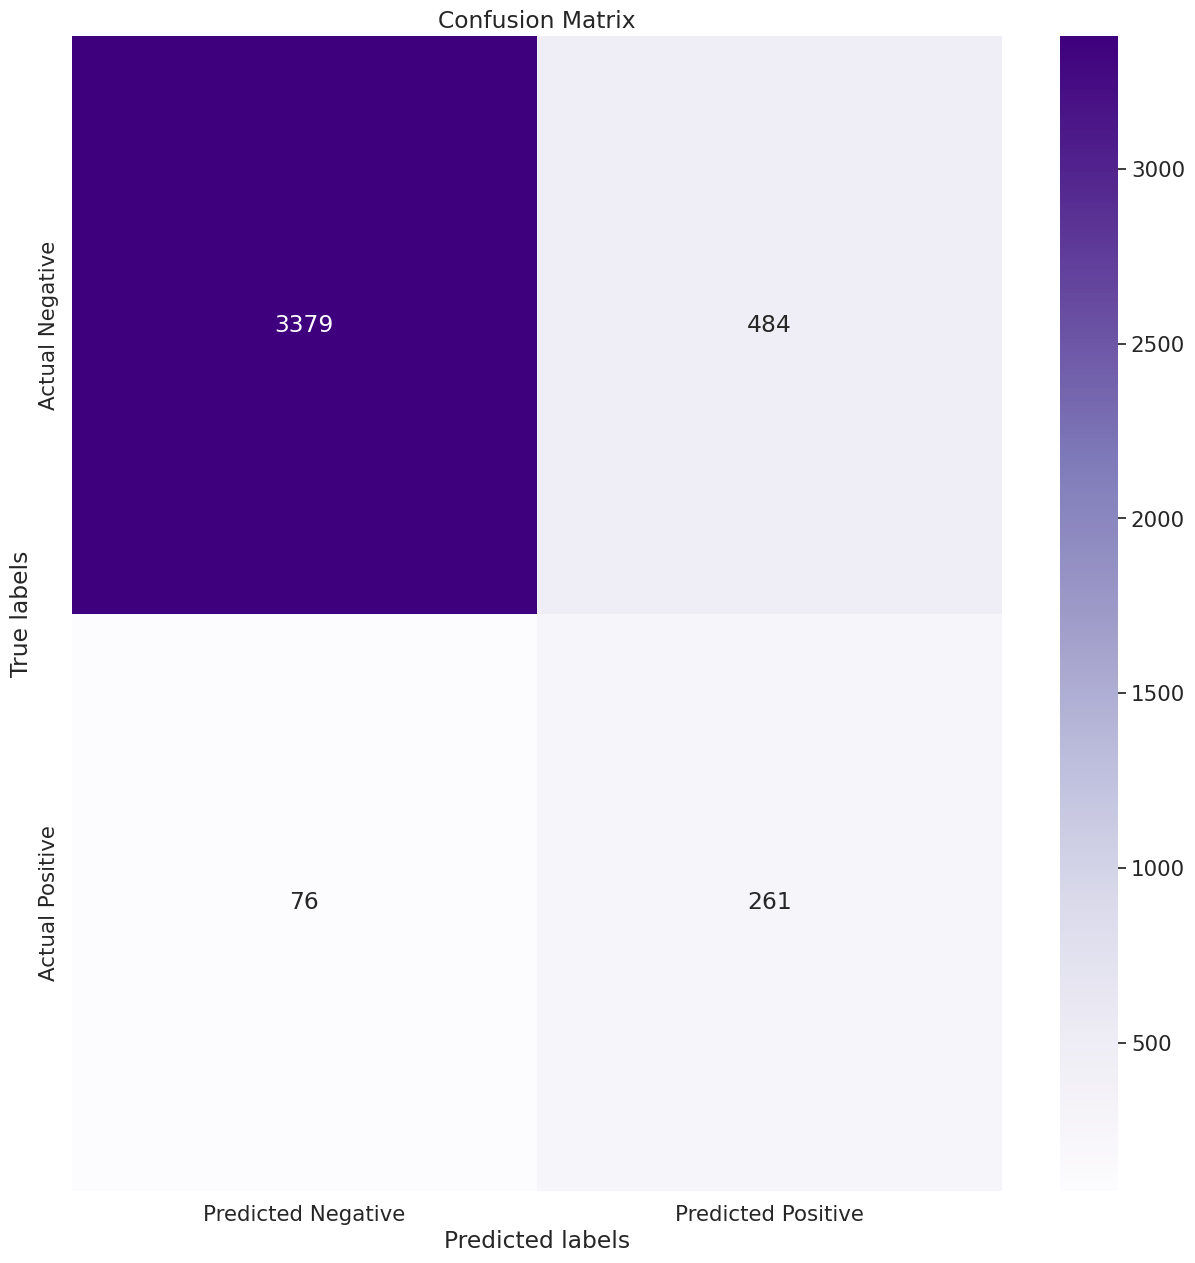

In [ ]:
# Define labels for the confusion matrix
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

# Reshape the confusion matrix into a 2x2 array
cm_array = np.array(confusion).reshape(2,2)

# Create the heatmap
plt.figure(figsize=(15,15))
sns.set(font_scale=1.4)
sns.heatmap(cm_array, annot=True, cmap='Purples', fmt='g', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

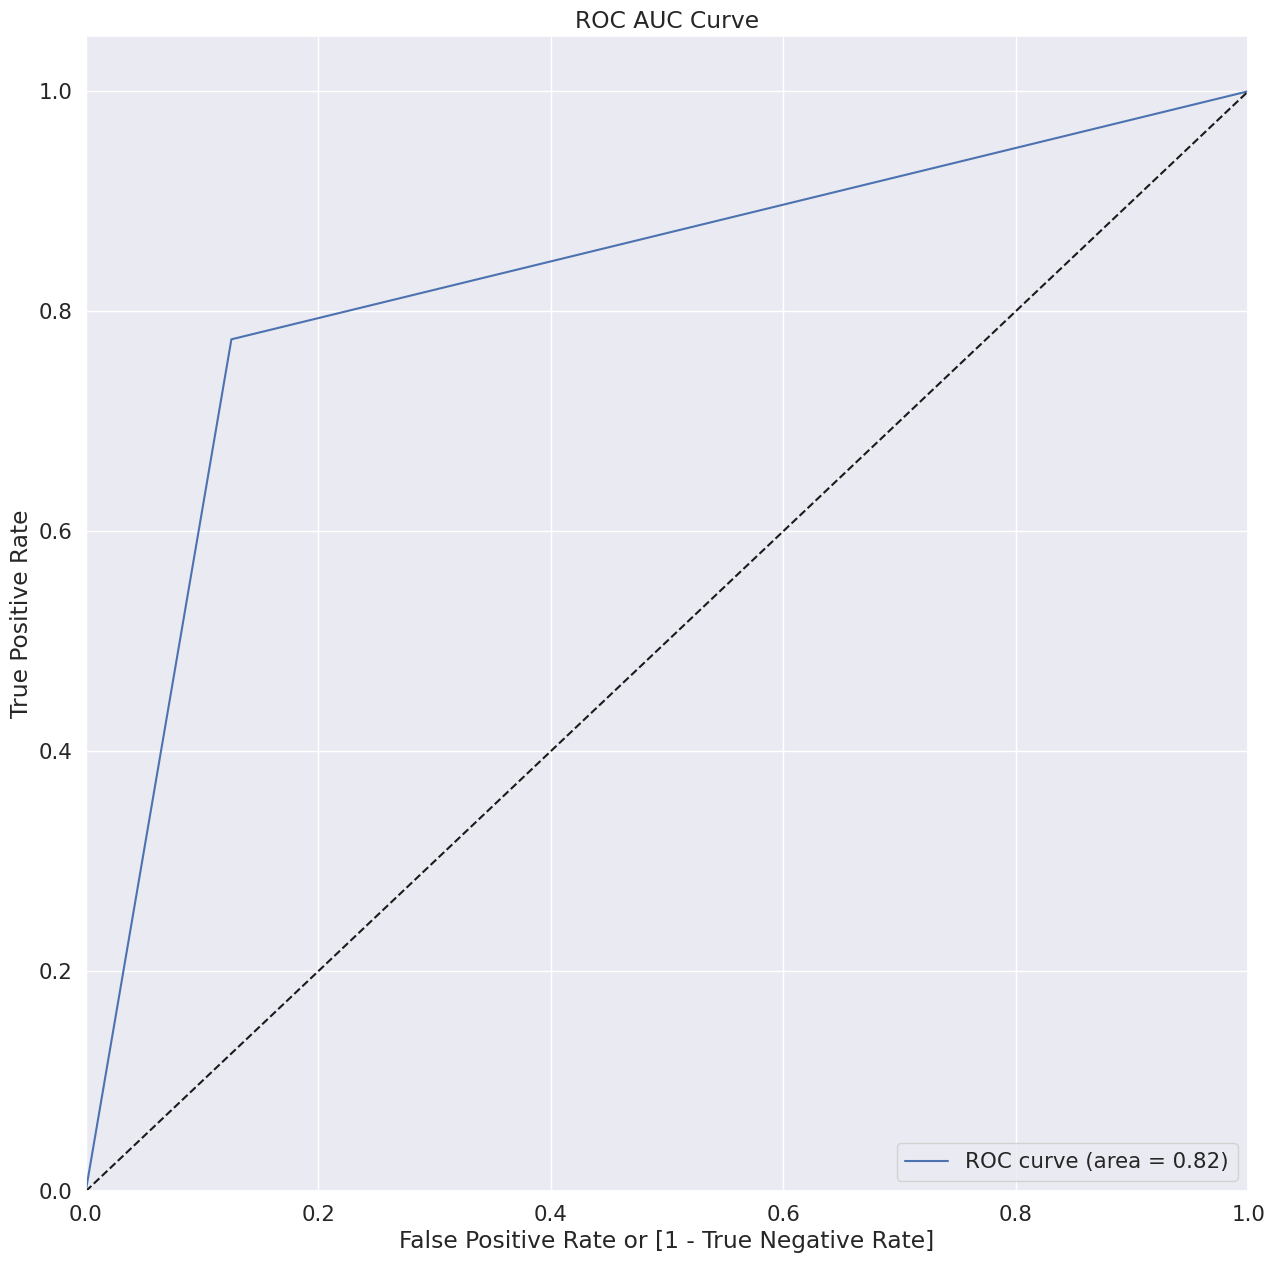

In [ ]:
def draw_roc(actual, probs):
    fpr, tpr, thresholds = roc_curve(actual, probs,drop_intermediate = False)
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(15, 15))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

# ROC curve
fpr, tpr, thresholds = draw_roc(y_val, y_val_pred)

In [ ]:
# ROC AUC Score
"{:2.2f}".format(roc_auc_score(y_val, y_val_pred))

'0.82'

### 6.5 Adaboost

In [ ]:
imputer = SimpleImputer(strategy='constant', fill_value=0)
scaler = StandardScaler()
pca = PCA(n_components=25)
smote = SMOTE(random_state=2)

In [ ]:
 #Create a pipeline
pipe = make_pipeline(
    imputer,
    smote,
    scaler,
    pca,
    AdaBoostClassifier(n_estimators=200, random_state=50)
)
# Build the model
adaboost_model = pipe.fit(X_train, y_train)
# Predict on train set using the best model
y_train_pred = adaboost_model.predict(X_train)

# Predict on train set using the validation model
y_test_pred = adaboost_model.predict(X_val)
# Metrics on the train set


In [ ]:

# Confusion matrix
cm = confusion_matrix(y_train, y_train_pred)
print('Confusion Matrix')
print()
print(cm)

# True Positives, False Positives, True Negatives, False Negatives
TP = cm[1, 1]
FP = cm[0, 1]
TN = cm[0, 0]
FN = cm[1, 0]

# Accuracy Score
accuracy = round((TP + TN) / (TP + FP + TN + FN), 4)

# Sensitivity (Recall or True Positive Rate)
sensitivity = round(TP / (TP + FN), 4)

# Specificity
specificity = round(TN / (TN + FP), 4)

# Precision
precision = round(TP / (TP + FP), 4)

# False Positive Rate
false_positive_rate = round(FP / (FP + TN), 4)

# True Positive Rate
true_positive_rate = sensitivity

# Create DataFrame with metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'False Positive Rate', 'True Positive Rate'],
    'Value': [accuracy, sensitivity, specificity, precision, false_positive_rate, true_positive_rate]
})

# Print metrics DataFrame
print(metrics_df)

Confusion Matrix

[[13476  1924]
 [  305  1093]]
                Metric   Value
0             Accuracy  0.8673
1          Sensitivity  0.7818
2          Specificity  0.8751
3            Precision  0.3623
4  False Positive Rate  0.1249
5   True Positive Rate  0.7818


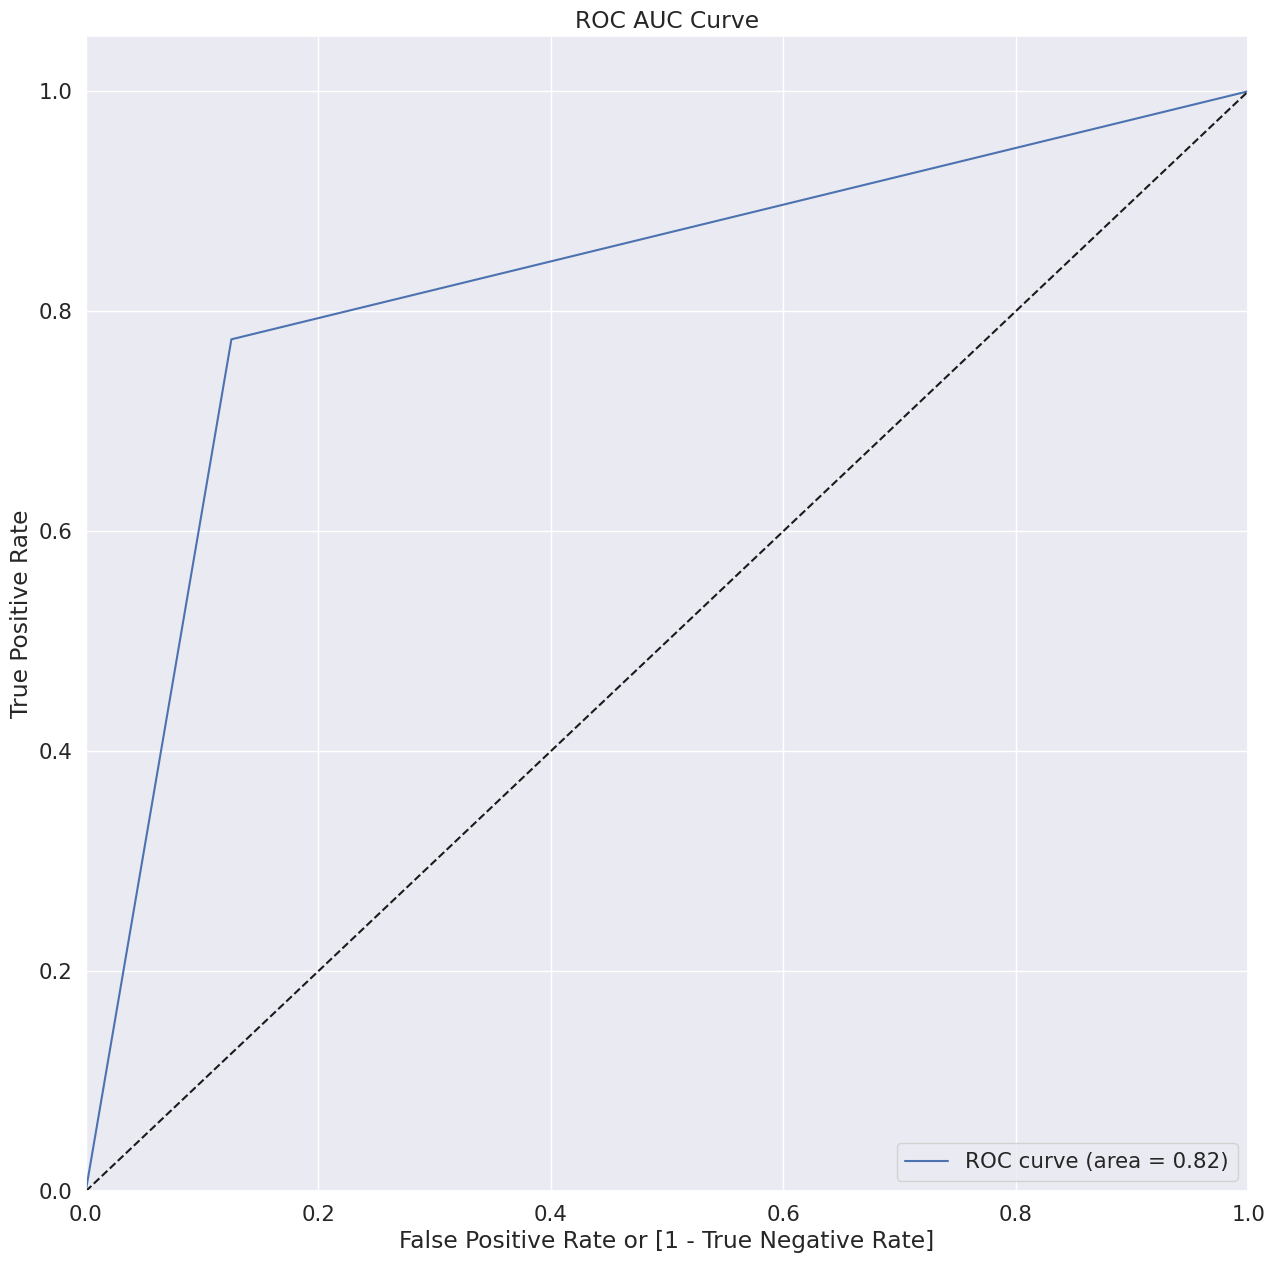

In [ ]:
# ROC curve
fpr, tpr, thresholds = draw_roc(y_val, y_val_pred)

###6.5 Model 2 Logistic Reqgression with PCA Experiment ( suggested model)

In [ ]:
ids = ['id','circle_id']
total_amounts = [i for i in list(data.columns) if re.search('total.+amt',i)]
total_outgoing_minutes = [i for i in list(data.columns) if re.search('total.+og.+mou',i)]
offnetwork_minutes = [i for i in list(data.columns) if re.search('offnet',i)]
average_revenue_3g = [i for i in list(data.columns) if re.search('arpu.+3g',i)]
average_revenue_2g = [i for i in list(data.columns) if re.search('arpu.+2g',i)]
volume_3g = [i for i in list(data.columns) if re.search('vol.+3g',i)]
volume_2g = [i for i in list(data.columns) if re.search('vol.+2g',i)]
age_on_network = [i for i in list(data.columns) if re.search('aon',i)]

In [ ]:
variables = [*ids,
             *total_amounts,
             *total_outgoing_minutes,
             *offnetwork_minutes,
             *average_revenue_3g,
             *average_revenue_2g,
             *volume_3g,
             *volume_2g,
             *age_on_network,
             'churn_probability']

In [415]:

featured = [
     'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
    'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6',
    'offnet_mou_7', 'offnet_mou_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
    'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
    'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon',
    'churn_probability'
]

new_selected_data = data.loc[:, featured]


In [416]:

new_selected_data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total_rech_amt_6   69999 non-null  int64  
 1   total_rech_amt_7   69999 non-null  int64  
 2   total_rech_amt_8   69999 non-null  int64  
 3   total_og_mou_6     69999 non-null  float64
 4   total_og_mou_7     69999 non-null  float64
 5   total_og_mou_8     69999 non-null  float64
 6   offnet_mou_6       67231 non-null  float64
 7   offnet_mou_7       67312 non-null  float64
 8   offnet_mou_8       66296 non-null  float64
 9   arpu_3g_6          69999 non-null  float64
 10  arpu_3g_7          69999 non-null  float64
 11  arpu_3g_8          69999 non-null  float64
 12  arpu_2g_6          69999 non-null  float64
 13  arpu_2g_7          69999 non-null  float64
 14  arpu_2g_8          69999 non-null  float64
 15  vol_3g_mb_6        69999 non-null  float64
 16  vol_3g_mb_7        699

In [417]:
new_selected_data.describe(include="all")

total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  total_og_mou_6  \
count      69999.000000      69999.000000      69999.000000    69999.000000   
mean         328.139788        322.376363        323.846355      306.451436   
std          404.211068        411.070120        426.181405      465.502866   
min            0.000000          0.000000          0.000000        0.000000   
25%          110.000000        100.000000         90.000000       44.780000   
50%          229.000000        220.000000        225.000000      145.280000   
75%          438.000000        430.000000        436.000000      374.305000   
max        35190.000000      40335.000000      45320.000000    10674.030000   

       total_og_mou_7  total_og_mou_8  offnet_mou_6  offnet_mou_7  \
count    69999.000000    69999.000000  67231.000000  67312.000000   
mean       310.572674      304.513065    198.874771    197.153383   
std        479.131770      477.936832    316.818355    322.482226   
min          0.000000        0.000000      0.000000      0.000000   
25%         42.910000       38.710000     34.860000     32.240000   
50%        141.230000      138.360000     96.480000     91.885000   
75%        380.045000      370.895000    232.990000    227.630000   
max       8285.640000    14043.060000   8362.360000   7043.980000   

       offnet_mou_8     arpu_3g_6  ...     arpu_2g_7     arpu_2g_8  \
count  66296.000000  69999.000000  ...  69999.000000  69999.000000   
mean     196.543577     22.605302  ...     21.909458     22.718590   
std      324.089234    104.553831  ...     97.431711     95.265909   
min        0.000000    -20.380000  ...    -13.090000    -55.830000   
25%       31.575000      0.000000  ...      0.000000      0.000000   
50%       91.800000      0.000000  ...      0.000000      0.000000   
75%      229.345000      0.000000  ...      0.000000      0.000000   
max    14007.340000   5054.370000  ...   4809.360000   3483.170000   

        vol_3g_mb_6   vol_3g_mb_7   vol_3g_mb_8   vol_2g_mb_6   vol_2g_mb_7  \
count  69999.000000  69999.000000  69999.000000  69999.000000  69999.000000   
mean     122.171882    128.934444    135.486541     51.773924     51.240204   
std      554.869965    554.096072    568.310234    212.513909    211.114667   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max    45735.400000  28144.120000  30036.060000  10285.900000   7873.550000   

        vol_2g_mb_8           aon  churn_probability  
count  69999.000000  69999.000000       69999.000000  
mean      50.127506   1220.639709           0.101887  
std      213.101403    952.426321           0.302502  
min        0.000000    180.000000           0.000000  
25%        0.000000    468.000000           0.000000  
50%        0.000000    868.000000           0.000000  
75%        0.000000   1813.000000           0.000000  
max    11117.610000   4337.000000           1.000000  

[8 rows x 23 columns]

In [419]:
X = new_selected_data.iloc[:, :-1]  # All columns except the last one
y = new_selected_data.iloc[:, -1]

X.shape, y.shape


((69999, 22), (69999,))

In [420]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 22), (14000, 22), (55999,), (14000,))

In [421]:
X_train.head()

total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  total_og_mou_6  \
19471               396               416               360          658.54   
16840               274               339               307          530.69   
13456                25                 9               134           28.53   
53294               210                 0                 0          155.36   
18942               504                 0                 0            0.00   

       total_og_mou_7  total_og_mou_8  offnet_mou_6  offnet_mou_7  \
19471          583.83          630.16          8.06          1.69   
16840          454.54          682.98        528.43        454.54   
13456            6.51           61.04         11.26          3.28   
53294            0.00            0.00         52.81         11.61   
18942            0.00            0.00           NaN           NaN   

       offnet_mou_8  arpu_3g_6  ...  arpu_2g_6  arpu_2g_7  arpu_2g_8  \
19471         56.56       0.00  ...       0.00        0.0        0.0   
16840        678.13       0.00  ...       0.00        0.0        0.0   
13456         51.73       0.00  ...       0.00        0.0        0.0   
53294          0.00       0.00  ...       0.00        0.0        0.0   
18942          0.00     424.34  ...     424.34        0.0        0.0   

       vol_3g_mb_6  vol_3g_mb_7  vol_3g_mb_8  vol_2g_mb_6  vol_2g_mb_7  \
19471         0.00          0.0          0.0         0.00          0.0   
16840         0.00          0.0          0.0         0.00          0.0   
13456         0.00          0.0          0.0         3.77          0.0   
53294         0.00          0.0          0.0         0.00          0.0   
18942      2027.82          0.0          0.0        10.07          0.0   

       vol_2g_mb_8  aon  
19471          0.0  235  
16840          0.0  228  
13456          0.0  992  
53294          0.0  679  
18942          0.0  777  

[5 rows x 22 columns]

<Axes: >

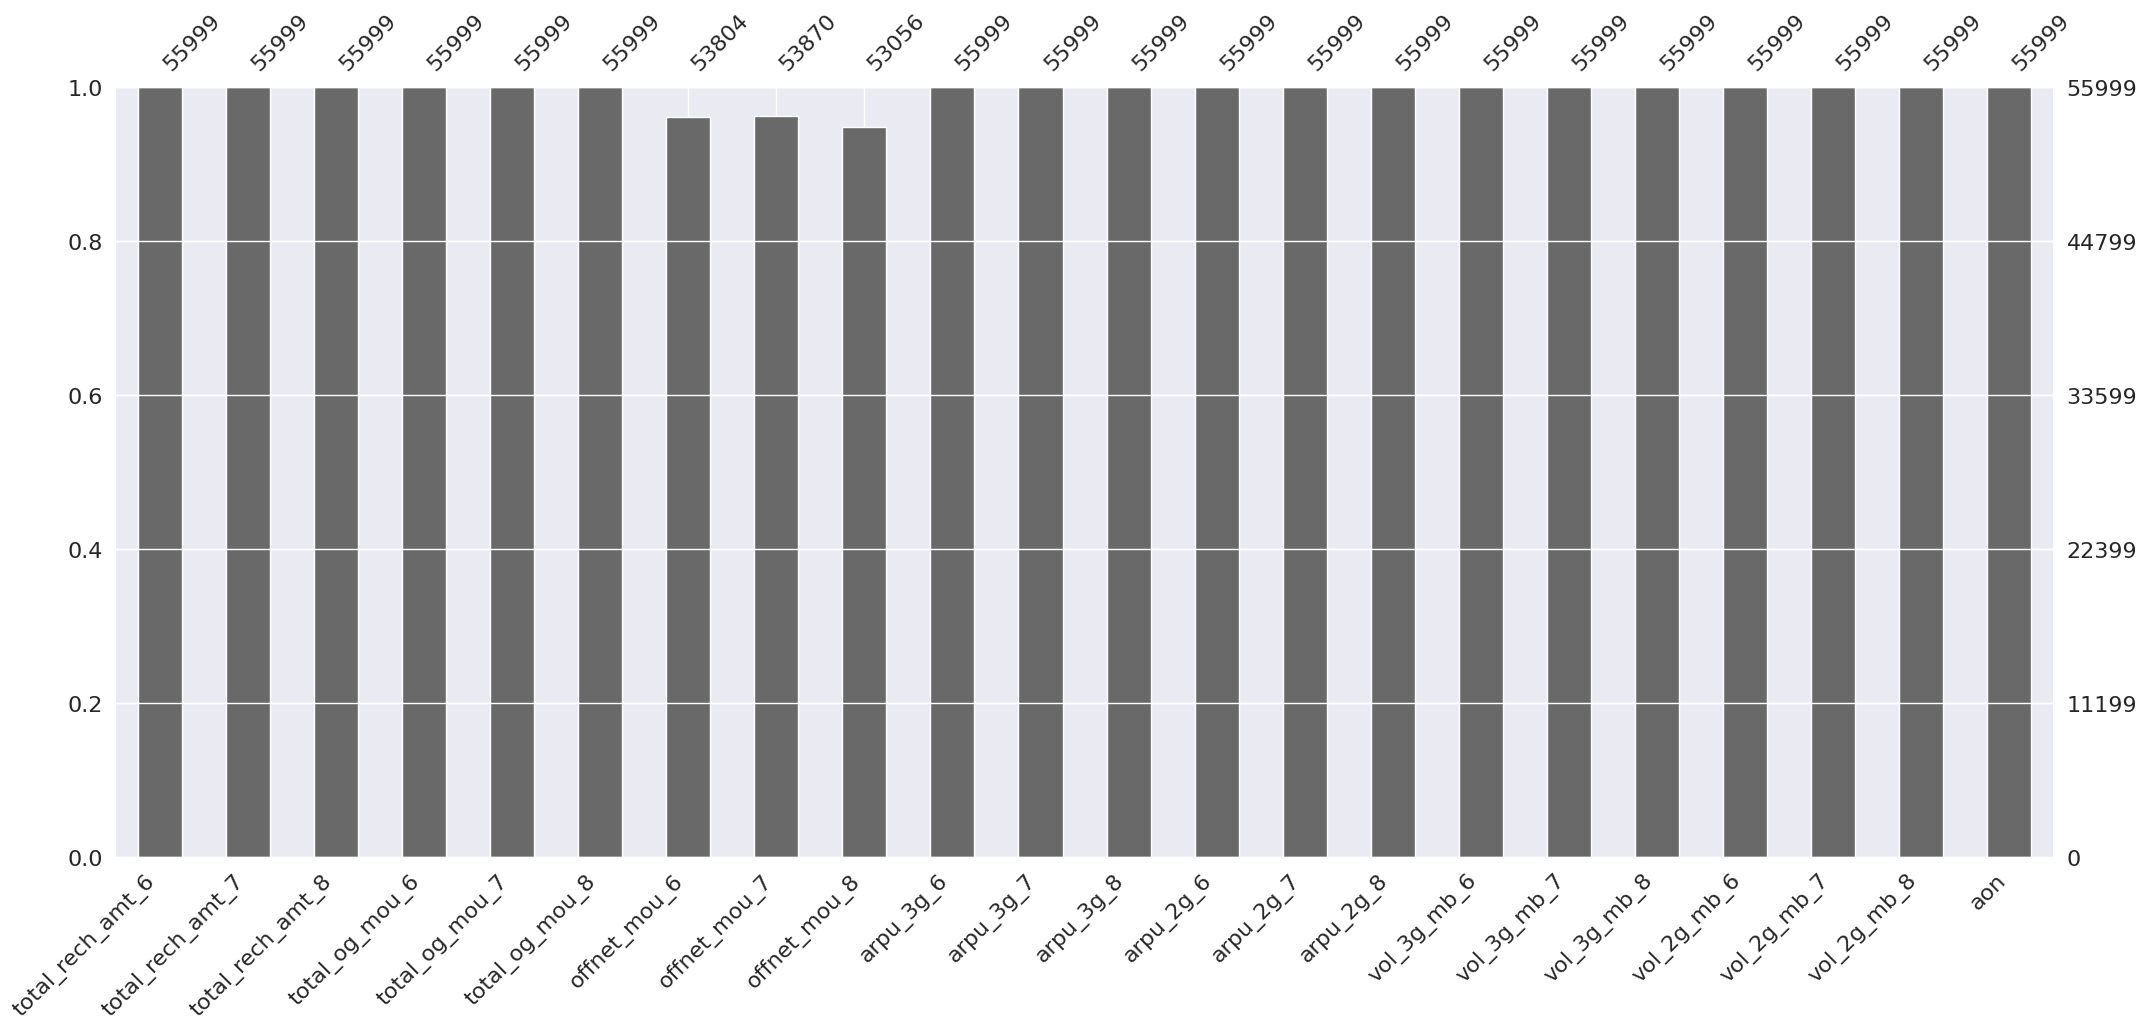

In [422]:
msno.bar(X_train)

<Axes: >

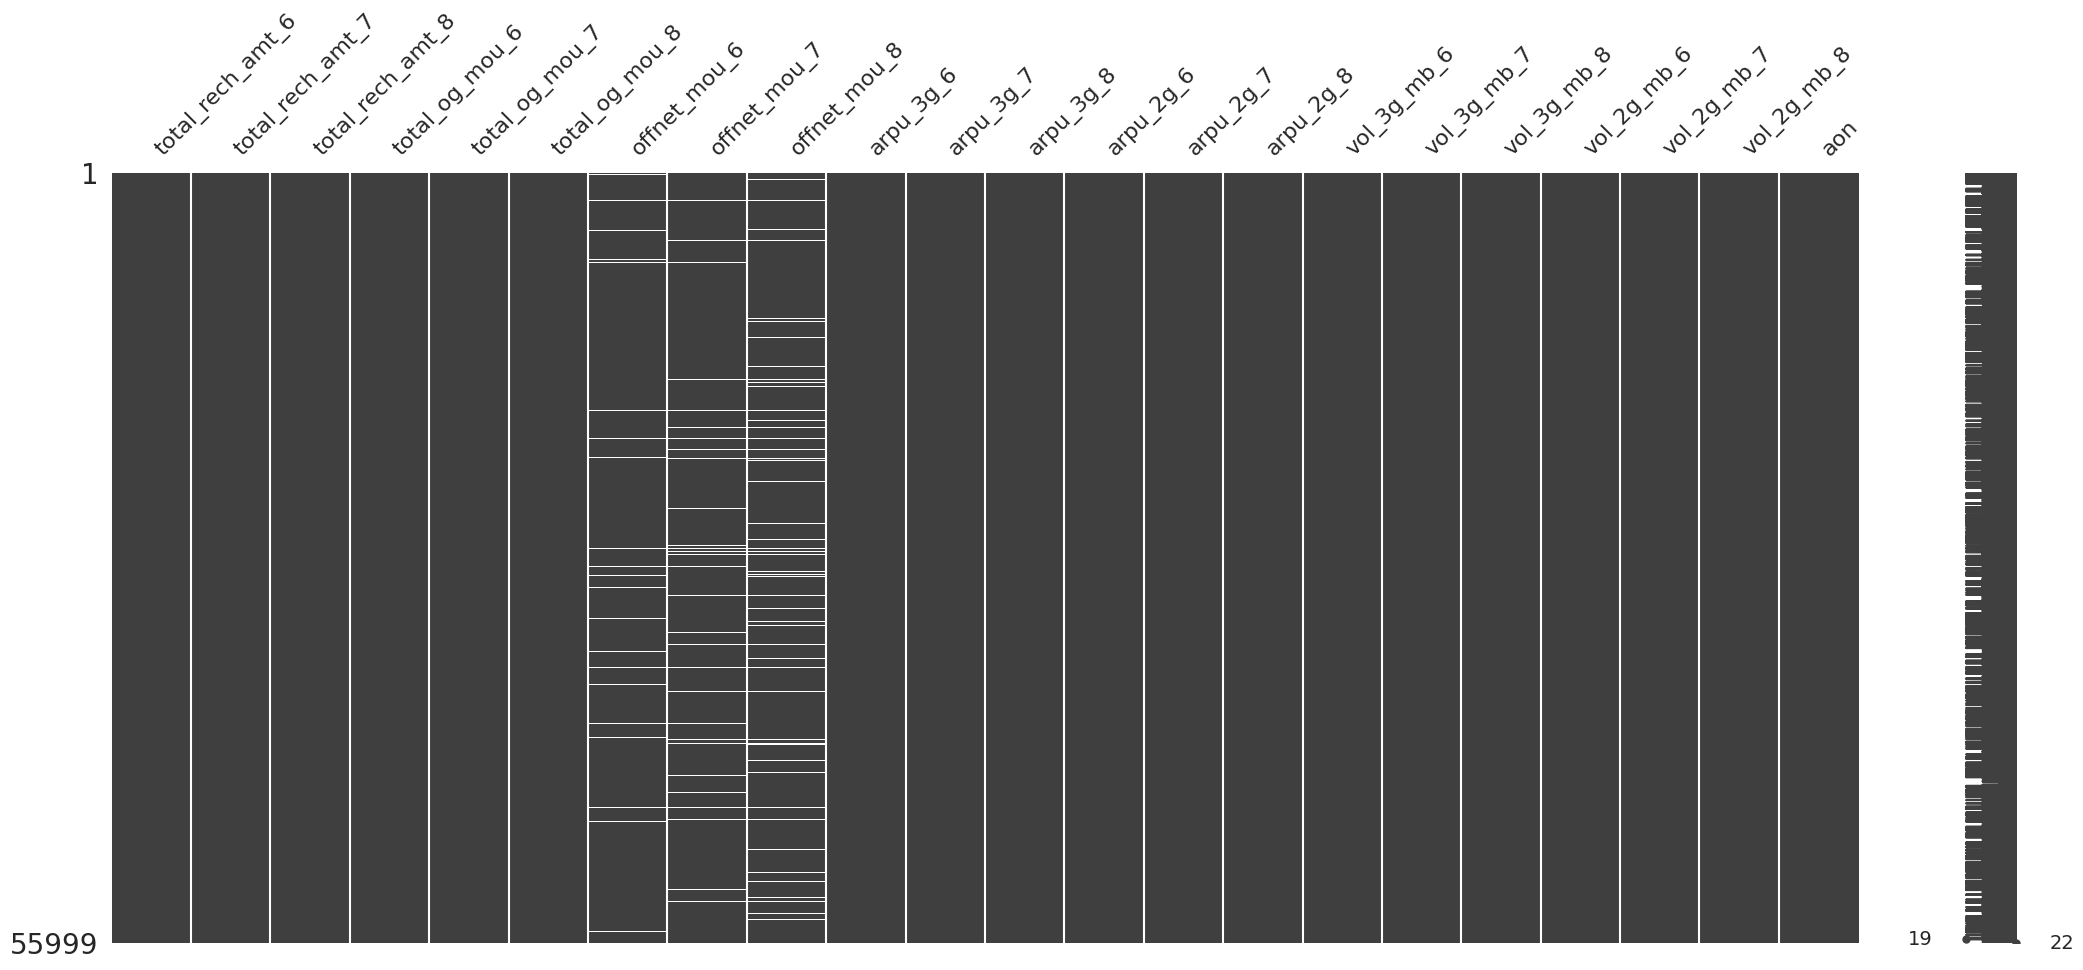

In [423]:
msno.matrix(X_train)

In [424]:
missing_data_percent = 100*X_train.isnull().sum()/len(y_train)
missing_data_percent

total_rech_amt_6    0.000000
total_rech_amt_7    0.000000
total_rech_amt_8    0.000000
total_og_mou_6      0.000000
total_og_mou_7      0.000000
total_og_mou_8      0.000000
offnet_mou_6        3.919713
offnet_mou_7        3.801854
offnet_mou_8        5.255451
arpu_3g_6           0.000000
arpu_3g_7           0.000000
arpu_3g_8           0.000000
arpu_2g_6           0.000000
arpu_2g_7           0.000000
arpu_2g_8           0.000000
vol_3g_mb_6         0.000000
vol_3g_mb_7         0.000000
vol_3g_mb_8         0.000000
vol_2g_mb_6         0.000000
vol_2g_mb_7         0.000000
vol_2g_mb_8         0.000000
aon                 0.000000
dtype: float64

In [425]:
newData = missing_data_percent[missing_data_percent.le(40)].index
newData

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
       'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon'],
      dtype='object')

In [426]:
X_train_filtered = X_train[newData]
X_train_filtered.shape

(55999, 22)

In [427]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8'], dtype='object')

In [428]:
print(impute_cols)
print(X_train_filtered.columns)

Index(['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8'], dtype='object')
Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
       'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon'],
      dtype='object')


In [429]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_train_filtered[impute_cols] = imp.fit_transform(X_train_filtered[impute_cols])

<Axes: >

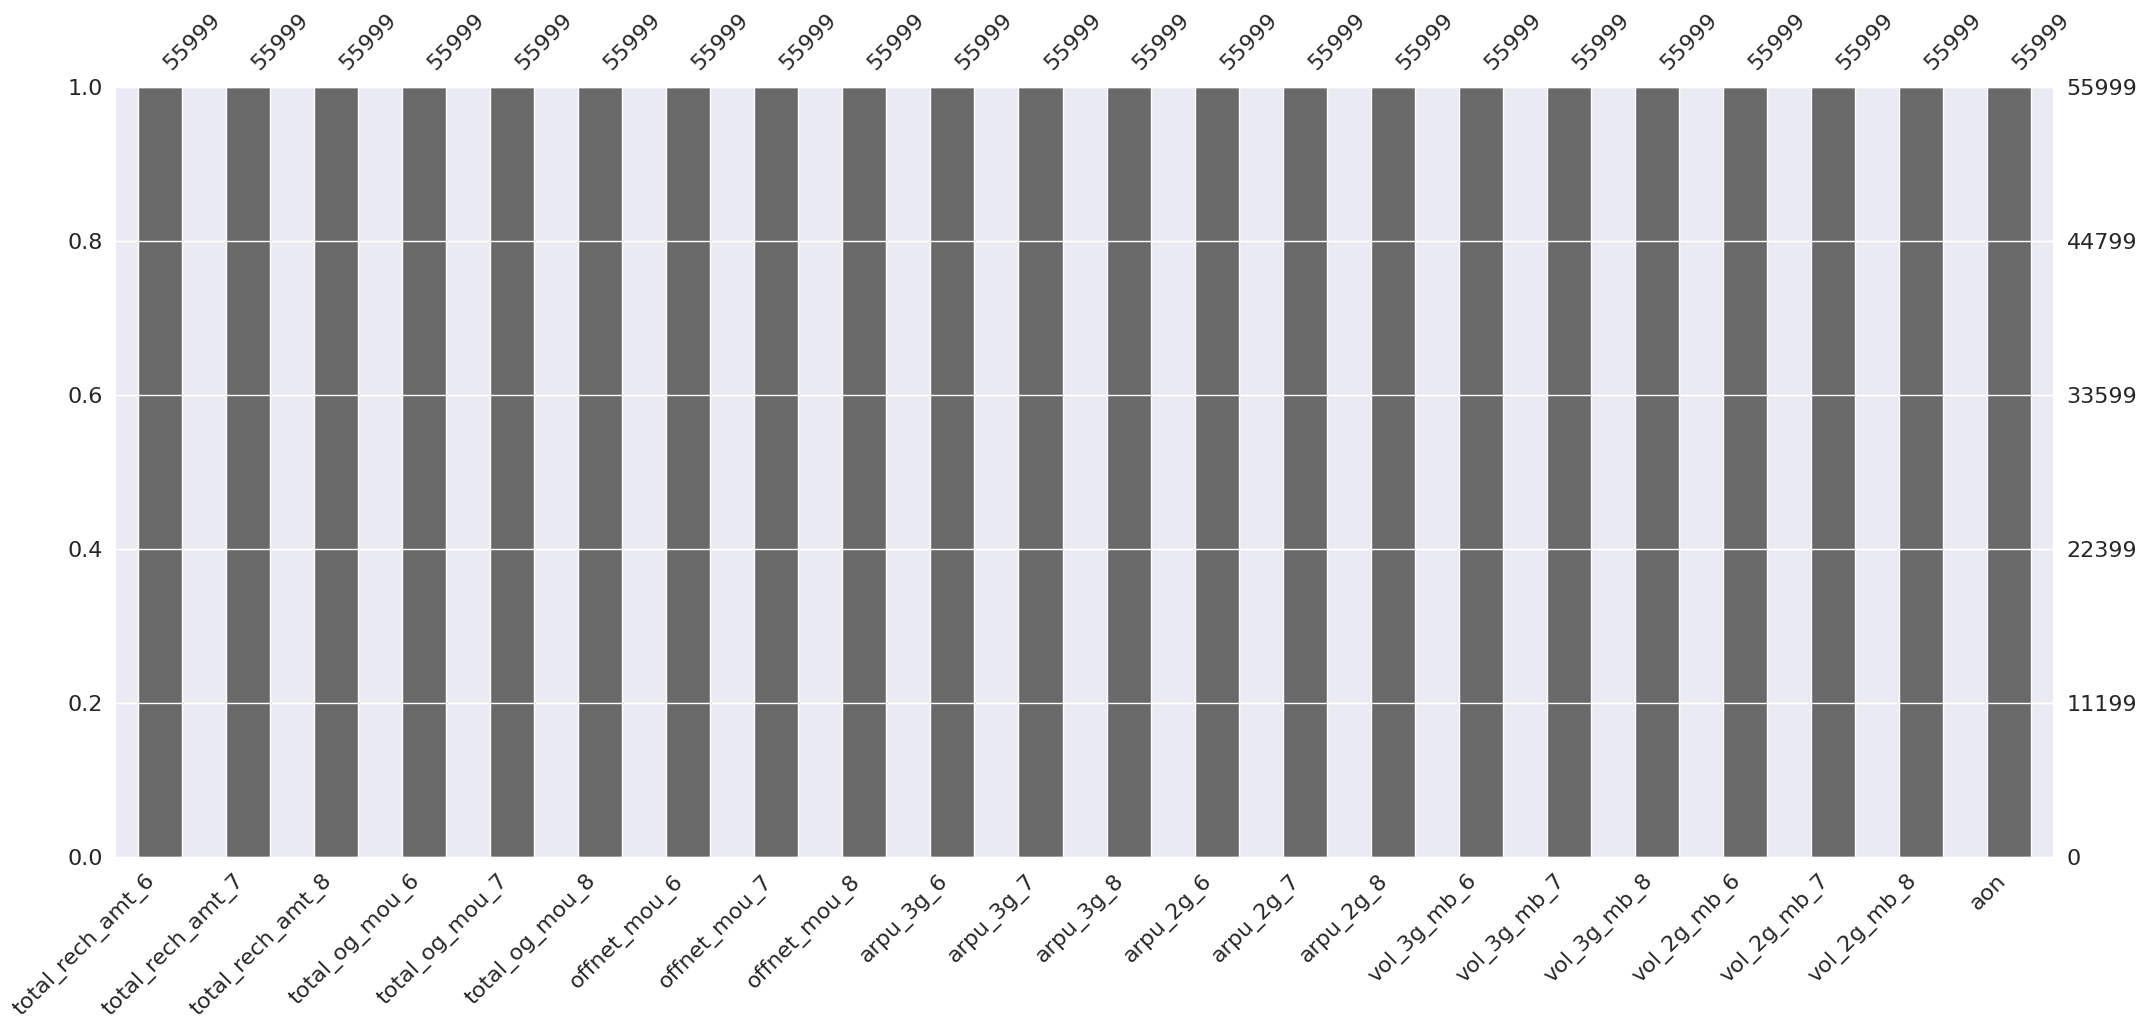

In [430]:
msno.bar(X_train_filtered)

In [431]:
X_train_filtered.describe()

total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  total_og_mou_6  \
count      55999.000000      55999.000000      55999.000000    55999.000000   
mean         328.947267        323.585064        325.047662      307.229219   
std          410.771890        414.898136        428.057123      464.540554   
min            0.000000          0.000000          0.000000        0.000000   
25%          110.000000        100.000000         90.500000       45.110000   
50%          230.000000        220.000000        226.000000      145.740000   
75%          440.000000        431.000000        439.000000      376.810000   
max        35190.000000      40335.000000      45320.000000    10674.030000   

       total_og_mou_7  total_og_mou_8  offnet_mou_6  offnet_mou_7  \
count    55999.000000    55999.000000  55999.000000  55999.000000   
mean       311.423533      306.068909    191.833612    190.593146   
std        478.267252      481.003588    310.880198    318.822140   
min          0.000000        0.000000      0.000000      0.000000   
25%         42.850000       38.710000     29.105000     26.780000   
50%        142.090000      138.510000     90.430000     86.130000   
75%        382.180000      374.110000    225.900000    219.570000   
max       8285.640000    14043.060000   5905.140000   6740.080000   

       offnet_mou_8     arpu_3g_6  ...     arpu_2g_6     arpu_2g_7  \
count  55999.000000  55999.000000  ...  55999.000000  55999.000000   
mean     187.406825     22.457665  ...     21.585309     21.941893   
std      320.064170    103.895695  ...     92.656085     97.442013   
min        0.000000    -20.380000  ...    -35.830000    -13.090000   
25%       23.890000      0.000000  ...      0.000000      0.000000   
50%       83.410000      0.000000  ...      0.000000      0.000000   
75%      218.500000      0.000000  ...      0.000000      0.000000   
max    14007.340000   5054.370000  ...   5054.350000   4809.360000   

          arpu_2g_8   vol_3g_mb_6   vol_3g_mb_7   vol_3g_mb_8   vol_2g_mb_6  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean      22.686994    120.510167    128.510798    134.401828     51.543753   
std       93.819007    541.258045    553.088475    555.918113    212.406365   
min      -55.830000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max     3483.170000  45735.400000  28144.120000  30036.060000  10285.900000   

        vol_2g_mb_7   vol_2g_mb_8           aon  
count  55999.000000  55999.000000  55999.000000  
mean      51.361278     50.282443   1223.078698  
std      210.483934    209.564450    953.555828  
min        0.000000      0.000000    180.000000  
25%        0.000000      0.000000    468.000000  
50%        0.000000      0.000000    870.000000  
75%        0.000000      0.000000   1822.500000  
max     7873.550000   8255.670000   4337.000000  

[8 rows x 22 columns]

**EDA**

<Axes: >

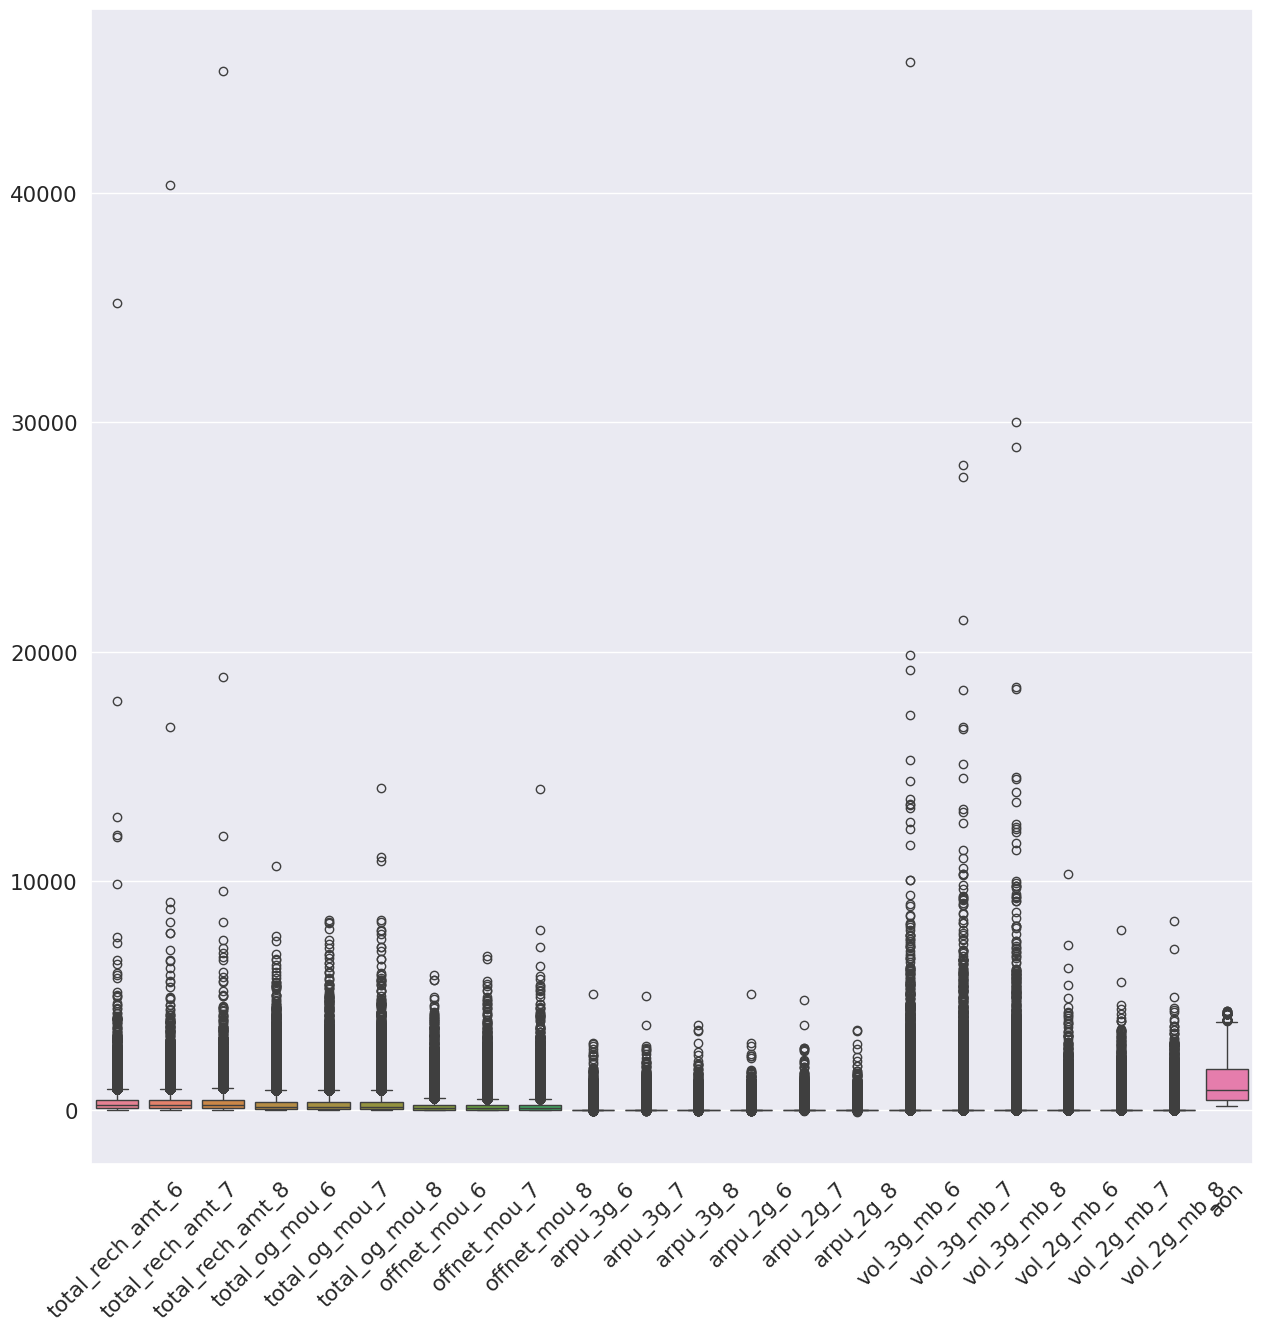

In [432]:
plt.figure(figsize=(15,15))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered)

In [433]:
def cap_outliers(series):
    lower_bound = series.quantile(0.05)
    upper_bound = series.quantile(0.95)
    return series.clip(lower_bound, upper_bound)


<Axes: >

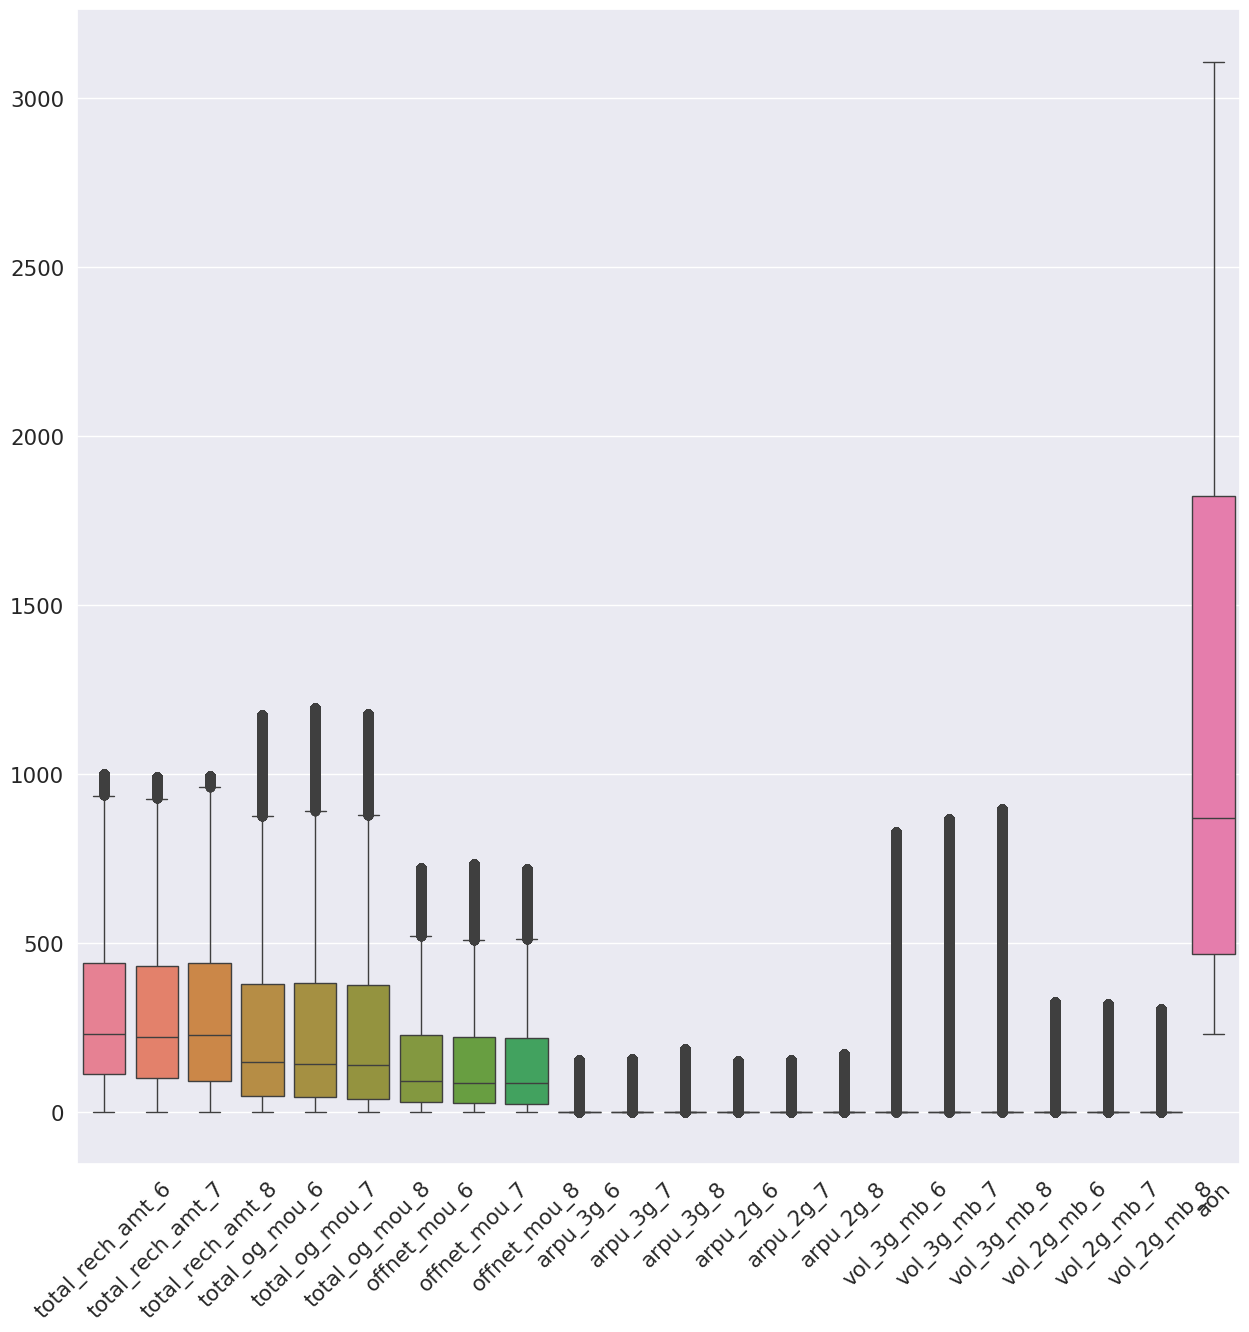

In [434]:
X_train_filtered1 = X_train_filtered.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,15))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered1)

In [435]:
# Select only numeric columns
X_train_numeric = X_train_filtered1.select_dtypes(include=[np.number])

# Apply scaling
scale = StandardScaler()
X_train_filtered2 = scale.fit_transform(X_train_numeric)


<Axes: >

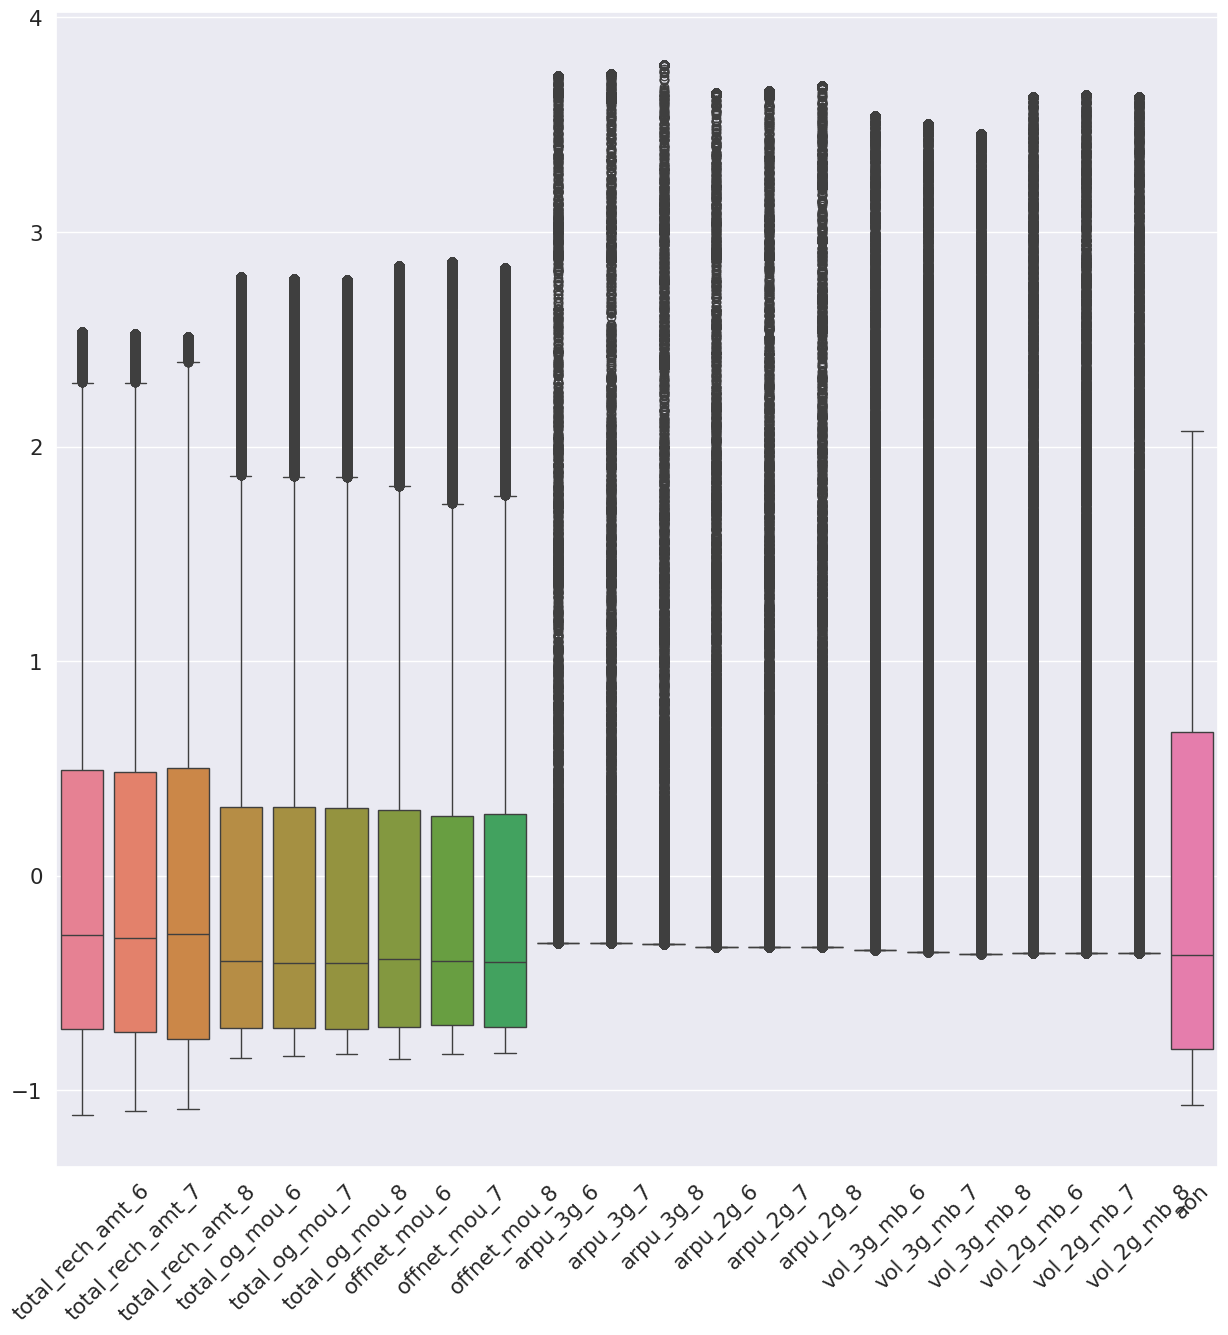

In [436]:
plt.figure(figsize=(15,15))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered2, columns=newData))

<Axes: >

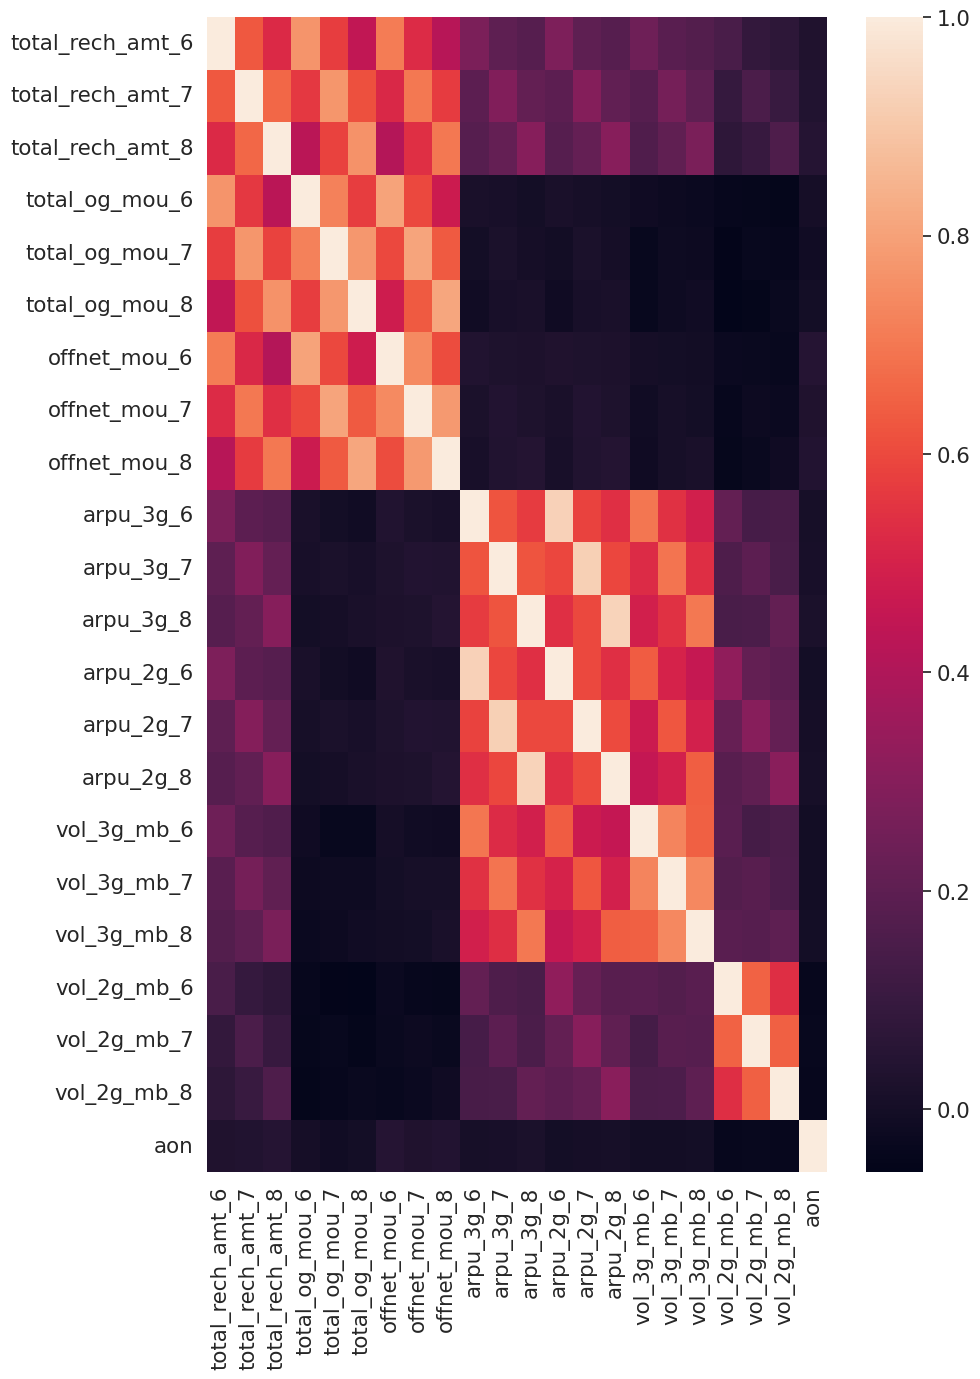

In [437]:
plt.figure(figsize=(10,15))
sns.heatmap(pd.DataFrame(X_train_filtered2, columns=newData).corr())

<Axes: xlabel='churn_probability', ylabel='Count'>

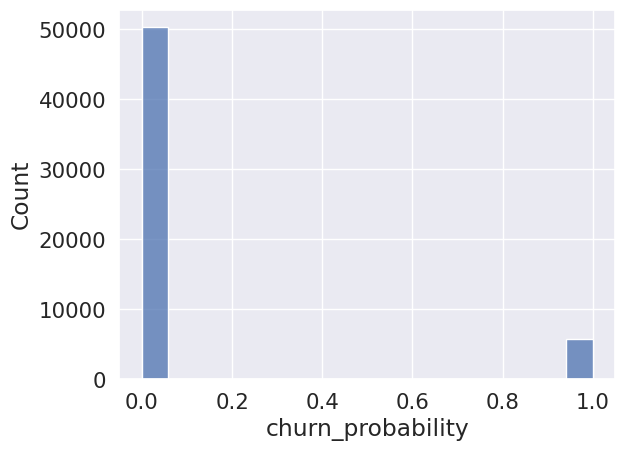

In [438]:
#Distribution for the churn probability
sns.histplot(y_train)

In [439]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train_filtered2, y_train)

RandomForestClassifier(n_jobs=-1)

In [440]:
feature_importances = pd.DataFrame({'col':newData, 'importance':rf.feature_importances_})

<BarContainer object of 22 artists>

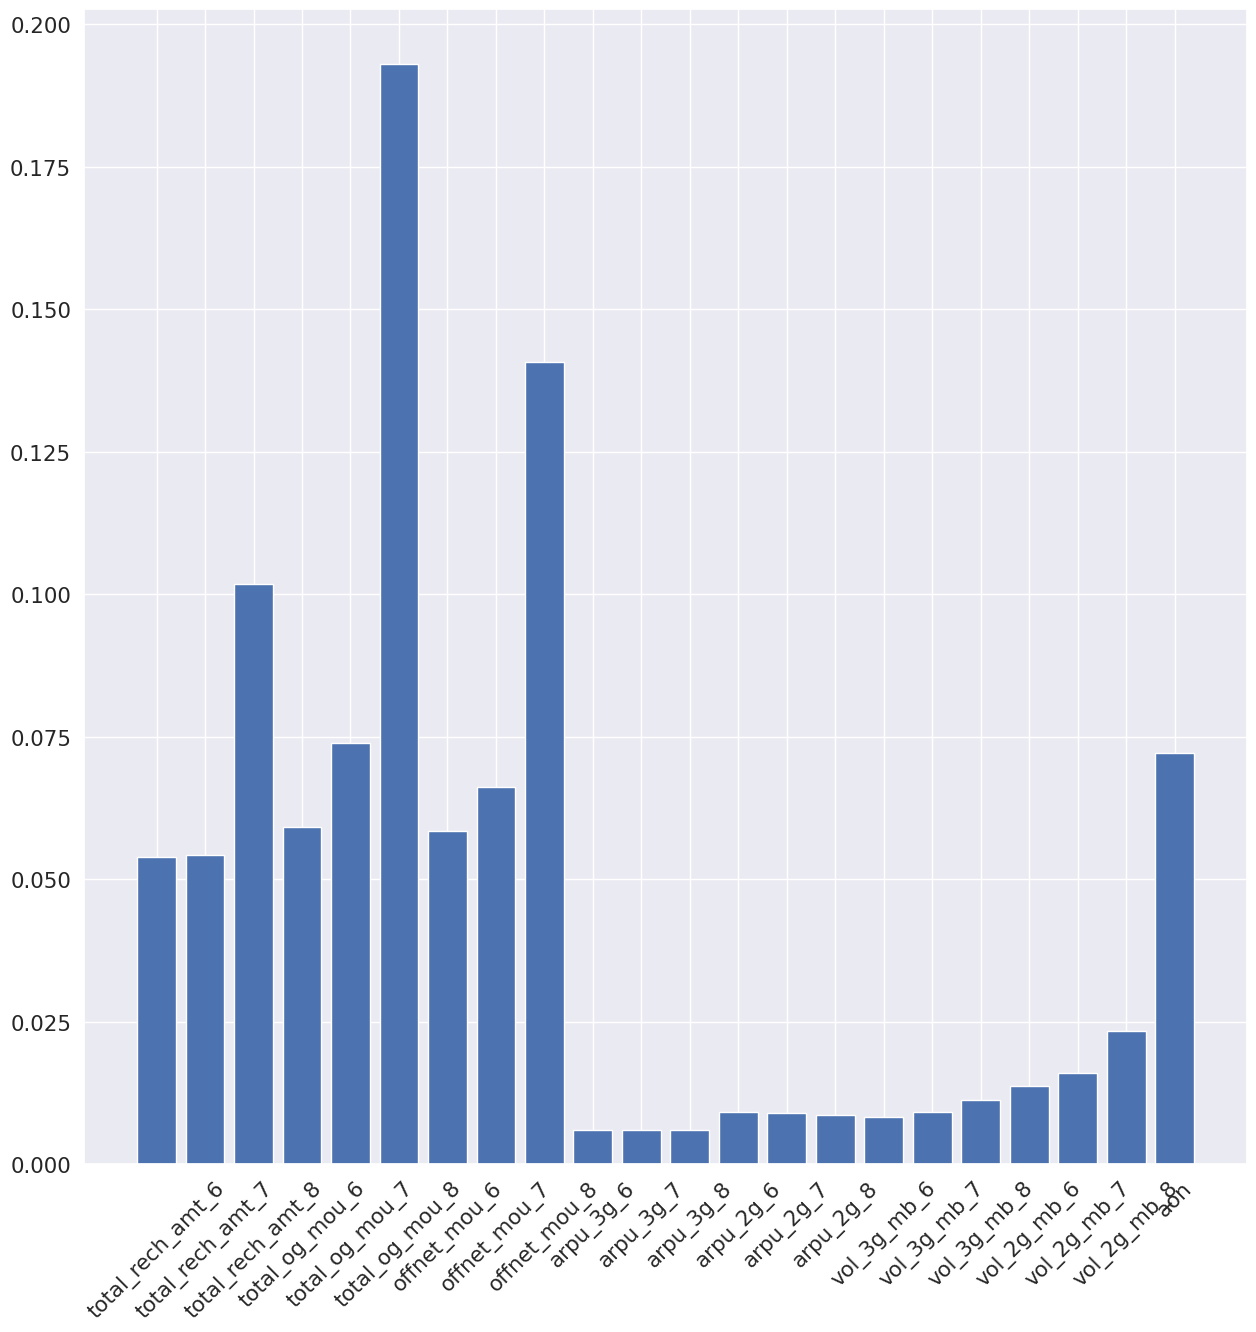

In [441]:
plt.figure(figsize=(15,15))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

<Axes: >

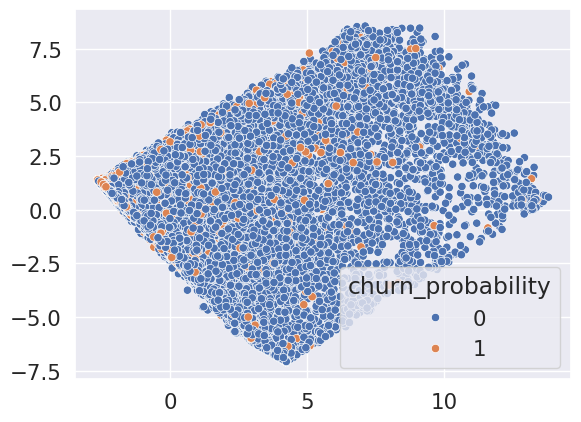

In [442]:
pca = PCA()
pca_components = pca.fit_transform(X_train_filtered2)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)

<Axes: >

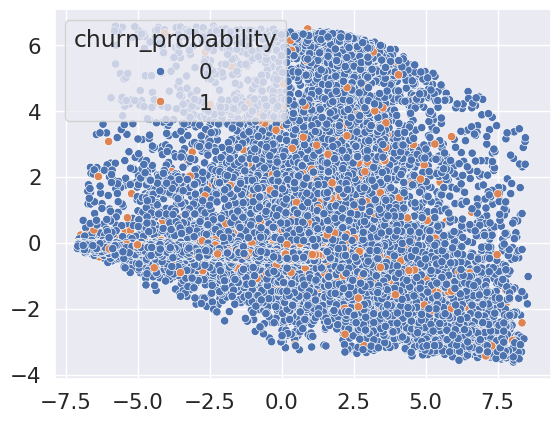

In [443]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)

In [444]:
y_train.shape

(55999,)

In [445]:
print(y_train)

19471    0
16840    0
13456    0
53294    0
18942    0
        ..
44913    0
59028    0
17712    0
59586    0
17224    0
Name: churn_probability, Length: 55999, dtype: int64


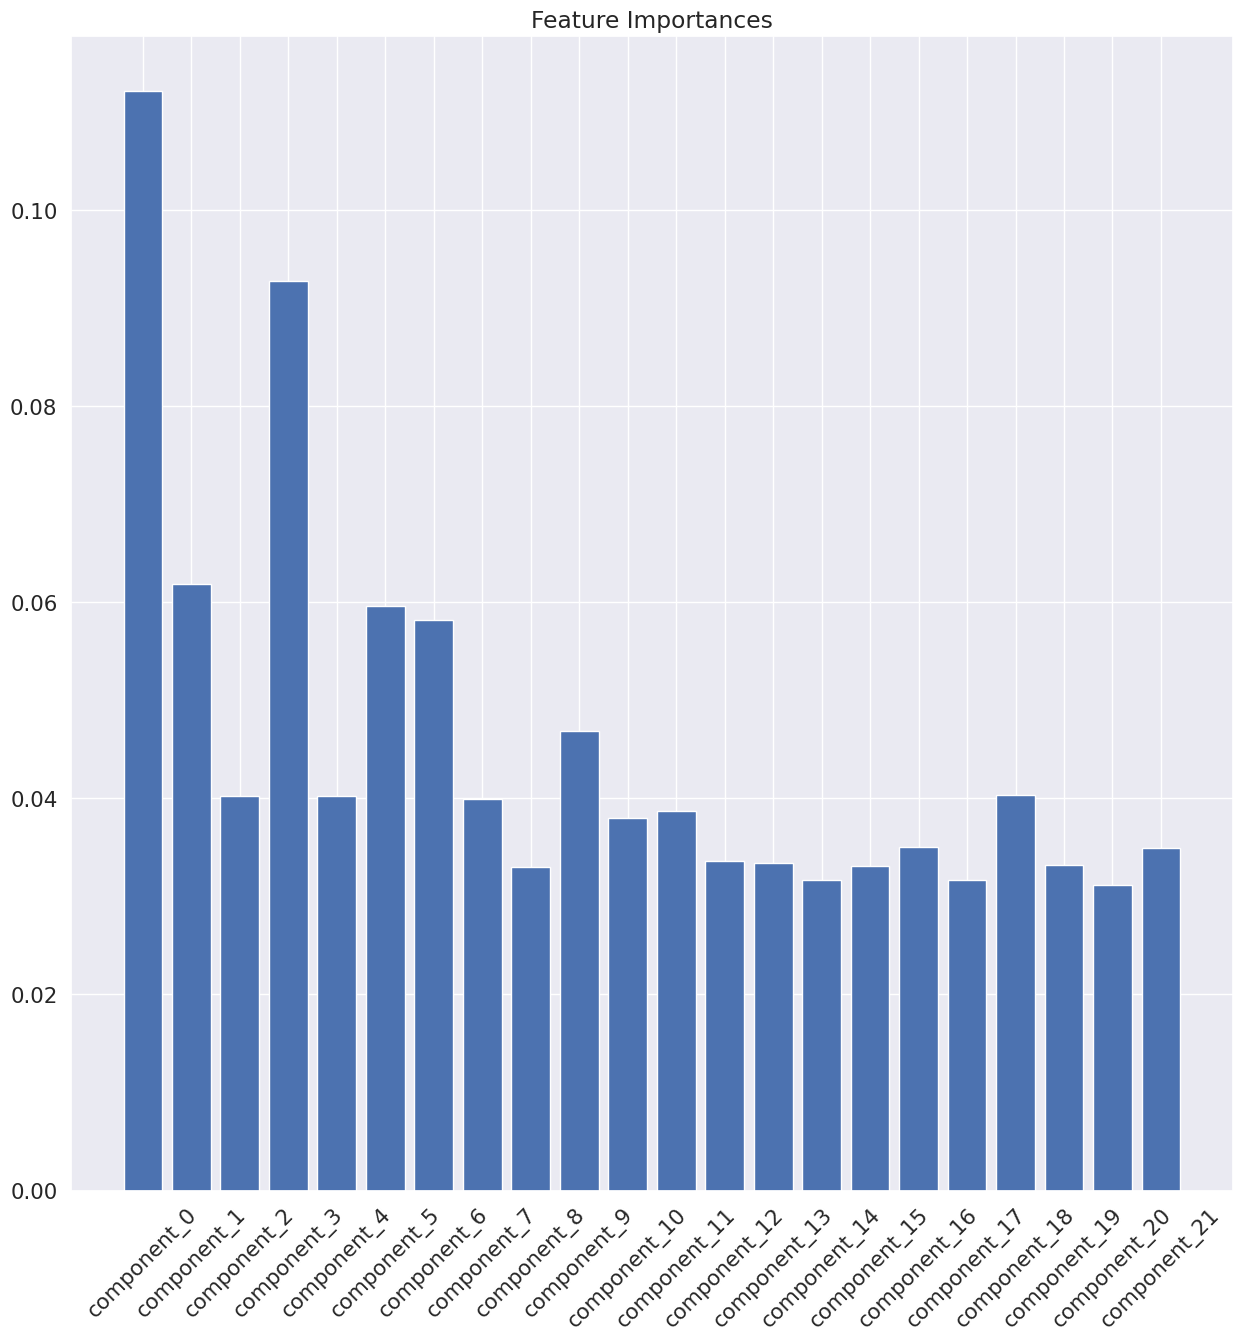

In [446]:
# Assuming rf is already fitted with pca_components and y_train
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(pca_components, y_train)

# Check the length of rf.feature_importances_
num_features = len(rf.feature_importances_)

# Create a DataFrame with the correct number of components
feature_importances = pd.DataFrame({
    'col': ['component_' + str(i) for i in range(num_features)],
    'importance': rf.feature_importances_
})

# Plot the feature importances
plt.figure(figsize=(15, 15))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])
plt.title("Feature Importances")
plt.show()

In [447]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(pca_components[:,:2], y_train)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [448]:
lr.score(pca_components[:,:2], y_train)

0.8982481830032679

In [449]:

imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=10)
lr = LogisticRegression(max_iter=1000, tol=0.001)

In [450]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [451]:
pipe.fit(X_train[newData], y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=10)),
                ('model', LogisticRegression(max_iter=1000, tol=0.001))])

In [452]:
train_score = pipe.score(X_train[newData], y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.9002482187181914


In [453]:
test_score = pipe.score(X_test[newData], y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.8980714285714285


In [454]:
confusion_matrix(y_train, pipe.predict(X_train[newData]))


array([[50039,   262],
       [ 5324,   374]])

In [455]:
precision_score(y_test, pipe.predict(X_test[newData]))

0.5222929936305732

In [456]:
recall_score(y_test, pipe.predict(X_test[newData]))

0.05718270571827057

In [457]:
sample.head()

id  churn_probability
0  69999                  0
1  70000                  0
2  70001                  0
3  70002                  0
4  70003                  0

In [458]:
unseen.head()

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0  69999   91.882   65.330   64.445        31.78        20.23        23.11   
1  70000  414.168  515.568  360.868        75.51        41.21        19.84   
2  70001  329.844  434.884  746.239         7.54         7.86         8.40   
3  70002   43.550  171.390   24.400         5.31         2.16         0.00   
4  70003  306.854  406.289  413.329       450.93       609.03       700.68   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  fb_user_6  fb_user_7  \
0         60.16         32.16         34.83  ...       -1.0       -1.0   
1        474.34        621.84        394.94  ...       -1.0       -1.0   
2         16.98         45.81         45.04  ...       -1.0       -1.0   
3         40.04        205.01         24.01  ...       -1.0       -1.0   
4         60.94         23.84         74.16  ...       -1.0       -1.0   

   fb_user_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  total_amt_6  \
0       -1.0  1692        0.00        0.00        0.00        103.0   
1       -1.0  2533        0.00        0.00        0.00        500.0   
2       -1.0   277      525.61      758.41      241.84        500.0   
3       -1.0  1244        0.00        0.00        0.00        110.0   
4       -1.0   462        0.00        0.00        0.00        356.0   

   total_amt_7  total_avg_amt_6_7  
0         90.0               96.5  
1        500.0              500.0  
2       1000.0              750.0  
3        260.0              185.0  
4        490.0              423.0  

[5 rows x 149 columns]

In [459]:
submission_data = unseen.set_index('id')[newData]
submission_data.shape

(30000, 22)

In [460]:

unseen['churn_probability'] = pipe.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()


id  churn_probability
0  69999                  0
1  70000                  0
2  70001                  0
3  70002                  0
4  70003                  0

In [461]:
output.to_csv('submission.csv',index=False)

## 7.Conclusion


After testing various models—including Logistic Regression with Recursive Feature Elimination (RFE), hyperparameter tuning, and PCA, as well as  Adaboost, and XGBoost classifiers—it's clear that Logistic Regression with PCA consistently achieves the highest sensitivity on both the training and validation sets. This indicates that Logistic Regression with PCA is the most reliable model, as others, despite showing good accuracy during training, tend to overfit and perform poorly on the test set.

Given the importance of minimizing churn in the telecom industry, sensitivity is the most critical metric. Therefore, Logistic Regression with PCA should be selected as the final model, as it best addresses this key criterion.